In [1]:
import os
import pandas as pd
from gensim.models import KeyedVectors
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

# Load dataset

In [7]:
dataset_path = os.path.join(os.getcwd(), 'dataset')

train_set = os.path.join(dataset_path, 'dataset_train_set.csv')
val_set = os.path.join(dataset_path, 'dataset_val_set.csv')
test_set = os.path.join(dataset_path, 'dataset_test_set.csv')
train_set_bin = os.path.join(dataset_path, 'dataset_train_set_bin.csv')
val_set_bin = os.path.join(dataset_path, 'dataset_val_set_bin.csv')
test_set_bin = os.path.join(dataset_path, 'dataset_test_set_bin.csv')

train_set_pkl = os.path.join(dataset_path, 'df_train.pkl')
val_set_pkl = os.path.join(dataset_path, 'df_val.pkl')
test_set_pkl = os.path.join(dataset_path, 'df_test.pkl')
train_set_bin_pkl = os.path.join(dataset_path, 'df_train_bin.pkl')
val_set_bin_pkl = os.path.join(dataset_path, 'df_val_bin.pkl')
test_set_bin_pkl = os.path.join(dataset_path, 'df_test_bin.pkl')

df_train = pd.read_csv(os.path.join(dataset_path, 'preprocessed-dataset.csv'))

# Format Dataset

In [35]:
class IndoBERTDataset(Dataset):
    def __init__(self, df, tokenizer, text_col='clean_text', label_col='label', max_len=128):
        self.texts = df[text_col].astype(str).tolist()
        self.labels = df[label_col].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Train Model 1

## LSTM

In [36]:
df_train = pd.read_csv(os.path.join(dataset_path, 'preprocessed-dataset.csv'))
X = df_train['clean_text'].astype(str).values
y = df_train['label'].values


# Encode label ke angka
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print("Kelas:", label_encoder.classes_)

# === Tokenisasi manual dan pembuatan vocab ===
def tokenize(text):
    return text.split()

tokenized_texts = [tokenize(t) for t in X]

# Bangun vocabulary (top 20.000 kata)
word_counts = Counter(word for tokens in tokenized_texts for word in tokens)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common(20000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# Konversi kata → indeks
def encode_text(tokens, vocab, max_len=200):
    encoded = [vocab.get(word, vocab['<UNK>']) for word in tokens]
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded

encoded_texts = np.array([encode_text(tokens, vocab) for tokens in tokenized_texts])

# === Split jadi Train / Valid / Test ===
X_train, X_temp, y_train, y_temp = train_test_split(encoded_texts, y_encoded, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Konversi ke tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.long)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

print("✅ Data siap: Train =", len(X_train), "| Valid =", len(X_valid), "| Test =", len(X_test))

Kelas: ['liga-indonesia' 'liga-inggris' 'liga-italia' 'liga-spanyol'
 'non-sepakbola']
✅ Data siap: Train = 1264 | Valid = 271 | Test = 272


In [37]:
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = NewsDataset(X_train_tensor, y_train_tensor)
valid_dataset = NewsDataset(X_valid_tensor, y_valid_tensor)
test_dataset  = NewsDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [38]:
def train_with_validation(model, embedding_dim, hidden_dim, train_loader, valid_loader, optimizer, criterion, device, num_epochs=8):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    min_val_loss = 99999
    
    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = output.argmax(dim=1)
            total_correct += (preds == y_batch).sum().item()
            total_samples += y_batch.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = total_correct / total_samples

        # === Validasi ===
        model.eval()
        val_loss, valid_correct, valid_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
                preds = output.argmax(dim=1)
                valid_correct += (preds == y_batch).sum().item()
                valid_samples += y_batch.size(0)

        val_loss /= len(valid_loader)
        val_acc = valid_correct / valid_samples

        # Simpan hasil tiap epoch
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)


        # save model
        if min_val_loss > val_loss:
            torch.save(model.state_dict(), f'./model/best-embedding_dim-{embedding_dim}-hidden_dim-{hidden_dim}.pth')
            min_val_loss = val_loss
            print(f"Saved new best model (val_loss: {val_loss:.4f})")
        else:
            torch.save(model.state_dict(), f'./model/last-embedding_dim-{embedding_dim}-hidden_dim-{hidden_dim}.pth')
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history


In [73]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # dua arah
        hidden = self.dropout(hidden)
        return self.fc(hidden)

In [76]:
model = BiLSTMModel(200, 32, 40, 5, 0.5)
model

BiLSTMModel(
  (embedding): Embedding(200, 32)
  (lstm): LSTM(32, 40, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=80, out_features=5, bias=True)
)

In [40]:
# LSTM Test
hidden_size = 2
input_size = 300
num_layers = 2
num_classes = 5
embedding_dim = 300
# Hyper Parameter
learning_rate = 1e-1
weight_decay = 5e-2
momentum = 0.9

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(vocab)

hyper_param = list()

for i in range(32, 289, 64):
    embedding_dim = i
    for j in range(32, 289, 64):
        hidden_dim = j
        hyper_param.append((embedding_dim, hidden_dim))



print(f"Training Model 1 (embedding_dim: {embedding_dim}, hidden_dim: {hidden_dim})")
modela = BiLSTMModel(vocab_size, embedding_dim=32, hidden_dim=32, output_dim=num_classes, dropout=0.5).to(device)
optimizer = optim.Adam(modela.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
history_a = train_with_validation(modela, embedding_dim, hidden_dim, train_loader, valid_loader, optimizer, criterion, device, num_epochs=10)

print(f"Training Model 2 (embedding_dim: {embedding_dim}, hidden_dim: {hidden_dim})")
modelb = BiLSTMModel(vocab_size, embedding_dim=64, hidden_dim=64, output_dim=num_classes, dropout=0.5).to(device)
optimizer = optim.Adam(modelb.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
history_b = train_with_validation(modelb, embedding_dim, hidden_dim, train_loader, valid_loader, optimizer, criterion, device, num_epochs=10)

print(f"Training Model 3 (embedding_dim: {embedding_dim}, hidden_dim: {hidden_dim})")
modelc = BiLSTMModel(vocab_size, embedding_dim=128, hidden_dim=128, output_dim=num_classes, dropout=0.5).to(device)
optimizer = optim.Adam(modelc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
history_c = train_with_validation(modelc, embedding_dim, hidden_dim, train_loader, valid_loader, optimizer, criterion, device, num_epochs=10)

Training Model 1 (embedding_dim: 288, hidden_dim: 288)
Saved new best model (val_loss: 1.5334)
Epoch 1/10 | Train Loss: 1.5873 | Val Loss: 1.5334 | Train Acc: 0.2824 | Val Acc: 0.3506
Saved new best model (val_loss: 1.4568)
Epoch 2/10 | Train Loss: 1.5189 | Val Loss: 1.4568 | Train Acc: 0.3513 | Val Acc: 0.3838
Saved new best model (val_loss: 1.3713)
Epoch 3/10 | Train Loss: 1.4449 | Val Loss: 1.3713 | Train Acc: 0.3948 | Val Acc: 0.4760
Saved new best model (val_loss: 1.3521)
Epoch 4/10 | Train Loss: 1.3299 | Val Loss: 1.3521 | Train Acc: 0.4715 | Val Acc: 0.4317
Saved new best model (val_loss: 1.0719)
Epoch 5/10 | Train Loss: 1.1669 | Val Loss: 1.0719 | Train Acc: 0.5665 | Val Acc: 0.6236
Saved new best model (val_loss: 0.9342)
Epoch 6/10 | Train Loss: 1.0129 | Val Loss: 0.9342 | Train Acc: 0.6210 | Val Acc: 0.6531
Saved new best model (val_loss: 0.7895)
Epoch 7/10 | Train Loss: 0.8719 | Val Loss: 0.7895 | Train Acc: 0.6899 | Val Acc: 0.7491
Epoch 8/10 | Train Loss: 0.7486 | Val Loss

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report, 
    confusion_matrix
)

# === BAGIAN 1: DEFINISI FUNGSI EVALUASI ===

def evaluate_model(model, test_loader, device, label_encoder):
    """
    Mengevaluasi model pada test loader dan mengembalikan laporan,
    skor, serta label dan prediksi mentah.
    """
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)

            # Cek tipe output (bisa tensor, bisa output Hugging Face)
            if hasattr(output, "logits"):
                logits = output.logits
            else:
                logits = output

            pred = logits.argmax(dim=1)
            preds.extend(pred.cpu().numpy())
            labels.extend(y_batch.cpu().numpy())

    # Pastikan label_encoder.classes_ tersedia
    try:
        class_names = label_encoder.classes_
    except AttributeError:
        print("Peringatan: label_encoder tidak memiliki atribut .classes_. Menggunakan nama default.")
        # Buat nama kelas placeholder jika tidak ada
        num_classes = len(np.unique(labels))
        class_names = [f"Kelas {i}" for i in range(num_classes)]

    report = classification_report(labels, preds, target_names=class_names, digits=4, zero_division=0)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    
    # Kembalikan labels dan preds untuk plotting
    return report, acc, f1, labels, preds

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    """
    Membuat visualisasi Confusion Matrix menggunakan Matplotlib.
    """
    cm = confusion_matrix(y_true, y_pred)
    n_classes = len(class_names)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Tampilkan matriks sebagai gambar (heatmap)
    cax = ax.imshow(cm, cmap='Blues')
    
    # Tambahkan color bar
    fig.colorbar(cax)
    
    # Atur label sumbu X (Predicted)
    ax.set_xticks(np.arange(n_classes))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_xlabel('Predicted Label')
    
    # Atur label sumbu Y (True)
    ax.set_yticks(np.arange(n_classes))
    ax.set_yticklabels(class_names)
    ax.set_ylabel('True Label')
    
    # Set judul
    ax.set_title(title)
    
    # Tambahkan anotasi (angka) di dalam sel
    threshold = cm.max() / 2.  # Ambang batas untuk mengubah warna teks
    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(j, i, f'{cm[i, j]}', # Teks adalah nilai dari cm[i, j]
                    ha='center',        # Rata tengah horizontal
                    va='center',        # Rata tengah vertikal
                    # Ubah warna teks menjadi putih untuk sel gelap
                    color='white' if cm[i, j] > threshold else 'black')
            
    plt.tight_layout() # Merapikan layout
    plt.show()

# === BAGIAN 2: EKSEKUSI EVALUASI DAN PLOTTING ===

# Pastikan variabel berikut sudah ada:
# modela, modelb, modelc, test_loader, device, label_encoder


In [46]:

print("======= Memulai Evaluasi Model =======")

# --- Evaluasi Model A ---
print("\n--- Mengevaluasi Model A ---")
report_at, bilstm_a_acct, bilstm_a_f1t, labels_at, preds_at = evaluate_model(modela, train_loader, device, label_encoder)
report_av, bilstm_a_accv, bilstm_a_f1v, labels_av, preds_av = evaluate_model(modela, valid_loader, device, label_encoder)
report_ats, bilstm_a_accts, bilstm_a_f1ts, labels_ats, preds_ats = evaluate_model(modela, test_loader, device, label_encoder)
print("Laporan Klasifikasi Model A (Train):")
print(report_at)
print("Laporan Klasifikasi Model A (Valid):")
print(report_av)
print("Laporan Klasifikasi Model A (Test):")
print(report_ats)

# plot_confusion_matrix(labels_ats, preds_ats, label_encoder.classes_, title='Confusion Matrix - Model A (Test)')

# --- Evaluasi Model B (Struktur disamakan) ---
print("\n--- Mengevaluasi Model B ---")
# Evaluasi pada Train, Valid, dan Test
report_bt, acc_bt, f1_bt, labels_bt, preds_bt = evaluate_model(modelb, train_loader, device, label_encoder)
report_bv, acc_bv, f1_bv, labels_bv, preds_bv = evaluate_model(modelb, valid_loader, device, label_encoder)
report_bts, acc_bts, f1_bts, labels_bts, preds_bts = evaluate_model(modelb, test_loader, device, label_encoder)

# Cetak semua laporan
print("Laporan Klasifikasi Model B (Train):")
print(report_bt)
print("Laporan Klasifikasi Model B (Valid):")
print(report_bv)
print("Laporan Klasifikasi Model B (Test):")
print(report_bts)

# Plot confusion matrix dari hasil test (...bts)
# plot_confusion_matrix(labels_bts, preds_bts, label_encoder.classes_, title='Confusion Matrix - Model B (Test)')

# --- Evaluasi Model C (Struktur disamakan) ---
print("\n--- Mengevaluasi Model C ---")
# Evaluasi pada Train, Valid, dan Test
report_ct, acc_ct, f1_ct, labels_ct, preds_ct = evaluate_model(modelc, train_loader, device, label_encoder)
report_cv, acc_cv, f1_cv, labels_cv, preds_cv = evaluate_model(modelc, valid_loader, device, label_encoder)
report_cts, acc_cts, f1_cts, labels_cts, preds_cts = evaluate_model(modelc, test_loader, device, label_encoder)

# Cetak semua laporan
print("Laporan Klasifikasi Model C (Train):")
print(report_ct)
print("Laporan Klasifikasi Model C (Valid):")
print(report_cv)
print("Laporan Klasifikasi Model C (Test):")
print(report_cts)

# Plot confusion matrix dari hasil test (...cts)
# plot_confusion_matrix(labels_cts, preds_cts, label_encoder.classes_, title='Confusion Matrix - Model C (Test)')

print("\n======= Evaluasi Selesai =======")

======= Memulai Evaluasi Model =======

--- Mengevaluasi Model A ---
Laporan Klasifikasi Model A (Train):
                precision    recall  f1-score   support

liga-indonesia     0.8775    0.9328    0.9043       238
  liga-inggris     0.8239    0.6332    0.7160       229
   liga-italia     0.7597    0.8596    0.8066       228
  liga-spanyol     0.9105    0.9630    0.9360       243
 non-sepakbola     0.9906    0.9724    0.9814       326

      accuracy                         0.8813      1264
     macro avg     0.8724    0.8722    0.8689      1264
  weighted avg     0.8820    0.8813    0.8785      1264

Laporan Klasifikasi Model A (Valid):
                precision    recall  f1-score   support

liga-indonesia     0.8049    0.8049    0.8049        41
  liga-inggris     0.7419    0.4694    0.5750        49
   liga-italia     0.6406    0.7736    0.7009        53
  liga-spanyol     0.7255    0.8810    0.7957        42
 non-sepakbola     0.9762    0.9535    0.9647        86

      accura

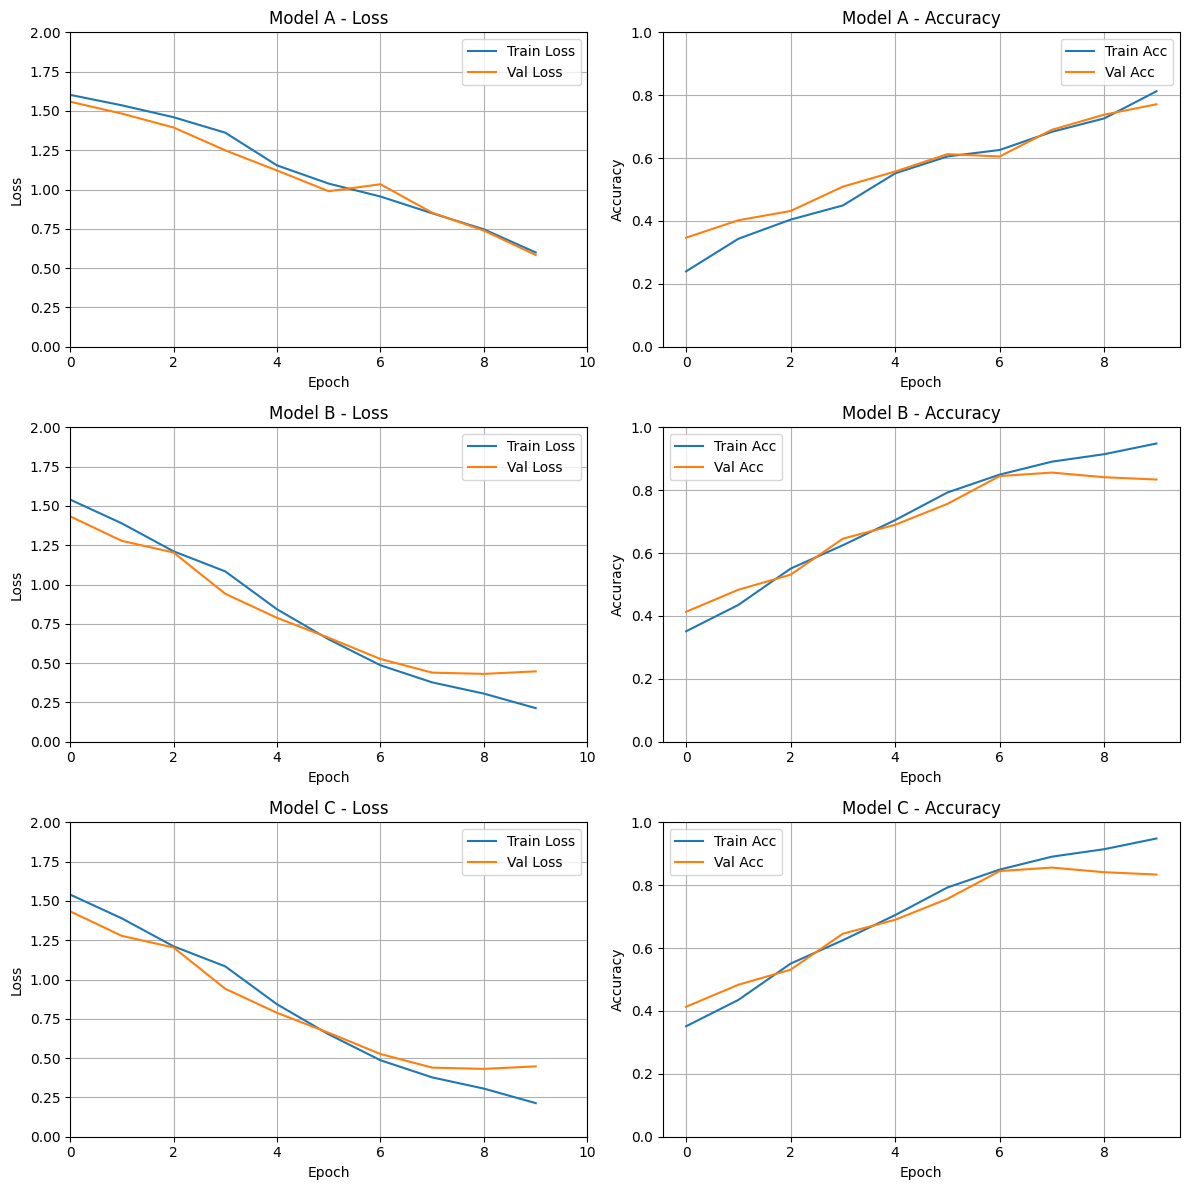

In [51]:
def plot_history_per_model(history_a, history_b, history_c):
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))

    # --- Model A Loss ---
    axes[0, 0].plot(history_a['train_loss'], label='Train Loss')
    axes[0, 0].plot(history_a['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Model A - Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_xlim(0, 10)
    axes[0, 0].set_ylim(0, 2)
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # --- Model A Accuracy ---
    axes[0, 1].plot(history_a['train_acc'], label='Train Acc')
    axes[0, 1].plot(history_a['val_acc'], label='Val Acc')
    axes[0, 1].set_title('Model A - Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # --- Model B Loss ---
    axes[1, 0].plot(history_b['train_loss'], label='Train Loss')
    axes[1, 0].plot(history_b['val_loss'], label='Val Loss')
    axes[1, 0].set_title('Model B - Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_xlim(0, 10)
    axes[1, 0].set_ylim(0, 2)
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # --- Model B Accuracy ---
    axes[1, 1].plot(history_b['train_acc'], label='Train Acc')
    axes[1, 1].plot(history_b['val_acc'], label='Val Acc')
    axes[1, 1].set_title('Model B - Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    # --- Model C Loss ---
    axes[2, 0].plot(history_b['train_loss'], label='Train Loss')
    axes[2, 0].plot(history_b['val_loss'], label='Val Loss')
    axes[2, 0].set_title('Model C - Loss')
    axes[2, 0].set_xlabel('Epoch')
    axes[2, 0].set_ylabel('Loss')
    axes[2, 0].set_xlim(0, 10)
    axes[2, 0].set_ylim(0, 2)
    axes[2, 0].legend()
    axes[2, 0].grid(True)

    # --- Model C Accuracy ---
    axes[2, 1].plot(history_b['train_acc'], label='Train Acc')
    axes[2, 1].plot(history_b['val_acc'], label='Val Acc')
    axes[2, 1].set_title('Model C - Accuracy')
    axes[2, 1].set_xlabel('Epoch')
    axes[2, 1].set_ylabel('Accuracy')
    axes[2, 1].set_ylim(0, 1)
    axes[2, 1].legend()
    axes[2, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Panggil fungsi
plot_history_per_model(history_a, history_b, history_c)

In [8]:
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
import numpy as np
import pandas as pd
import transformers

print("Transformers version:", transformers.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"💻 Using device: {device}")

import accelerate, transformers
print("Transformers version:", transformers.__version__)
print("Accelerate version:", accelerate.__version__)

Transformers version: 4.57.1
💻 Using device: cuda
Transformers version: 4.57.1
Accelerate version: 1.11.0


In [13]:
X = df_train['clean_text'].astype(str).values
y = df_train['label'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print("Kelas:", label_encoder.classes_)

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Data split -> Train: {len(X_train)}, Valid: {len(X_valid)}, Test: {len(X_test)}")

Kelas: ['liga-indonesia' 'liga-inggris' 'liga-italia' 'liga-spanyol'
 'non-sepakbola']
Data split -> Train: 1445, Valid: 181, Test: 181


In [14]:
class IndoBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [15]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

train_dataset = IndoBERTDataset(X_train, y_train, tokenizer, max_len=128)
valid_dataset = IndoBERTDataset(X_valid, y_valid, tokenizer, max_len=128)
test_dataset  = IndoBERTDataset(X_test, y_test, tokenizer, max_len=128)

In [16]:
def get_training_args(model_name, lr, epochs, log_dir):
    return TrainingArguments(
        output_dir=f'./results_{model_name}',
        do_train=True,
        do_eval=True,
        save_steps=500,                  # simpan setiap 500 langkah
        save_total_limit=2,              # maksimal simpan 2 checkpoint
        learning_rate=lr,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_dir=f'./{log_dir}',
        logging_steps=50
    )

In [ ]:
print("Fine-tuning IndoBERT-A (LR=1e-5, Epochs=3)")
num_classes=5
# model_a = BertForSequenceClassification.from_pretrained(
#     'indobenchmark/indobert-base-p1',
#     num_labels=num_classes
# ).to(device)

model_a = BertForSequenceClassification.from_pretrained(
    './results_indobert_A/checkpoint-543',
    num_labels=num_classes
).to(device)

training_args_a = get_training_args(
    model_name="indobert_A",
    lr=2e-5,
    epochs=3,
    log_dir="logs_A"
)

trainer_a = Trainer(
    model=model_a,
    args=training_args_a,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)

trainer_a.train()

print("\n=== Evaluasi IndoBERT-A (Train Set) ===")
pred_at = trainer_a.predict(train_dataset)
y_pred_at = np.argmax(pred_at.predictions, axis=1)

print(classification_report(y_train, y_pred_at, target_names=label_encoder.classes_, digits=4))

print("\n=== Evaluasi IndoBERT-A (Val Set) ===")
pred_av = trainer_a.predict(valid_dataset)
y_pred_av = np.argmax(pred_av.predictions, axis=1)

print(classification_report(y_valid, y_pred_av, target_names=label_encoder.classes_, digits=4))

print("\n=== Evaluasi IndoBERT-A (Test Set) ===")
pred_ats = trainer_a.predict(test_dataset)
y_pred_ats = np.argmax(pred_ats.predictions, axis=1)

print(classification_report(y_test, y_pred_ats, target_names=label_encoder.classes_, digits=4))

model_a.to('cpu')
del model_a
torch.cuda.empty_cache()

trainer_a.model.to('cpu')
del trainer_a.model
del trainer_a
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

Fine-tuning IndoBERT-A (LR=1e-5, Epochs=3)


C:\Users\vinco\AppData\Local\Temp\ipykernel_37836\1621950478.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_a = Trainer(



=== Evaluasi IndoBERT-A (Train Set) ===


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000       271
  liga-inggris     0.9926    0.9926    0.9926       269
   liga-italia     0.9962    0.9923    0.9942       261
  liga-spanyol     0.9964    1.0000    0.9982       275
 non-sepakbola     1.0000    1.0000    1.0000       369

      accuracy                         0.9972      1445
     macro avg     0.9970    0.9970    0.9970      1445
  weighted avg     0.9972    0.9972    0.9972      1445


=== Evaluasi IndoBERT-A (Val Set) ===


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        26
  liga-inggris     0.9677    0.9677    0.9677        31
   liga-italia     1.0000    0.9697    0.9846        33
  liga-spanyol     0.9600    1.0000    0.9796        24
 non-sepakbola     1.0000    1.0000    1.0000        67

      accuracy                         0.9890       181
     macro avg     0.9855    0.9875    0.9864       181
  weighted avg     0.9892    0.9890    0.9890       181


=== Evaluasi IndoBERT-A (Test Set) ===


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        30
  liga-inggris     1.0000    0.9286    0.9630        28
   liga-italia     0.9714    1.0000    0.9855        34
  liga-spanyol     0.9667    1.0000    0.9831        29
 non-sepakbola     1.0000    1.0000    1.0000        60

      accuracy                         0.9890       181
     macro avg     0.9876    0.9857    0.9863       181
  weighted avg     0.9893    0.9890    0.9888       181



In [19]:
# print("\n=== Evaluasi IndoBERT-A (Test Set) ===")
# from sklearn.metrics import confusion_matrix, classification_report
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# print(classification_report(y_test, y_pred_a, target_names=label_encoder.classes_, digits=4))

# # --- LANGKAH 1: Hitung Confusion Matrix ---
# cm = confusion_matrix(y_test, y_pred_a)

# # --- LANGKAH 2: Dapatkan Nama Kelas ---
# class_names = label_encoder.classes_

# # --- LANGKAH 3: Visualisasi Confusion Matrix ---
# plt.figure(figsize=(8, 6)) # Ukuran plot

# # sns.heatmap untuk membuat visualisasi
# sns.heatmap(cm,
#             annot=True,        # Menampilkan angka di dalam sel
#             fmt='d',           # Format angka sebagai integer
#             cmap='Blues',      # Skema warna
#             xticklabels=class_names, # Label di sumbu X (predicted)
#             yticklabels=class_names) # Label di sumbu Y (true)

# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for IndoBERT-A (Test Set)')
# plt.show()

# print("\nConfusion Matrix Visualization generated.")

In [23]:
print("Fine-tuning IndoBERT-B (LR=3e-5, Epochs=4)")

# model_b = BertForSequenceClassification.from_pretrained(
#     'indobenchmark/indobert-base-p1',
#     num_labels=num_classes
# )

num_classes=5

model_b = BertForSequenceClassification.from_pretrained(
    './results_indobert_B/checkpoint-724',
    num_labels=num_classes
)

training_args_b = get_training_args(
    model_name="indobert_B",
    lr=3e-5,
    epochs=4,
    log_dir="logs_B"
)

trainer_b = Trainer(
    model=model_b,
    args=training_args_b,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)

# trainer_b.train()

print("\n=== Evaluasi IndoBERT-B (Train Set) ===")
pred_bt = trainer_b.predict(train_dataset)
y_pred_bt = np.argmax(pred_bt.predictions, axis=1)

print(classification_report(y_train, y_pred_bt, target_names=label_encoder.classes_, digits=4))

print("\n=== Evaluasi IndoBERT-B (Val Set) ===")
pred_bv = trainer_b.predict(valid_dataset)
y_pred_bv = np.argmax(pred_bv.predictions, axis=1)

print(classification_report(y_valid, y_pred_bv, target_names=label_encoder.classes_, digits=4))

print("\n=== Evaluasi IndoBERT-B (Test Set) ===")
pred_bts = trainer_b.predict(test_dataset)
y_pred_bts = np.argmax(pred_bts.predictions, axis=1)

print(classification_report(y_test, y_pred_bts, target_names=label_encoder.classes_, digits=4))


model_b.to('cpu')
del model_b
torch.cuda.empty_cache()

trainer_b.model.to('cpu')
del trainer_b.model
del trainer_b
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()


Fine-tuning IndoBERT-B (LR=3e-5, Epochs=4)


C:\Users\vinco\AppData\Local\Temp\ipykernel_37836\3708090484.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_b = Trainer(



=== Evaluasi IndoBERT-B (Train Set) ===


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000       271
  liga-inggris     0.9963    0.9926    0.9944       269
   liga-italia     0.9924    0.9962    0.9943       261
  liga-spanyol     1.0000    1.0000    1.0000       275
 non-sepakbola     1.0000    1.0000    1.0000       369

      accuracy                         0.9979      1445
     macro avg     0.9977    0.9977    0.9977      1445
  weighted avg     0.9979    0.9979    0.9979      1445


=== Evaluasi IndoBERT-B (Val Set) ===


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        26
  liga-inggris     0.9677    0.9677    0.9677        31
   liga-italia     1.0000    0.9697    0.9846        33
  liga-spanyol     0.9600    1.0000    0.9796        24
 non-sepakbola     1.0000    1.0000    1.0000        67

      accuracy                         0.9890       181
     macro avg     0.9855    0.9875    0.9864       181
  weighted avg     0.9892    0.9890    0.9890       181


=== Evaluasi IndoBERT-B (Test Set) ===


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        30
  liga-inggris     1.0000    0.9286    0.9630        28
   liga-italia     0.9714    1.0000    0.9855        34
  liga-spanyol     0.9667    1.0000    0.9831        29
 non-sepakbola     1.0000    1.0000    1.0000        60

      accuracy                         0.9890       181
     macro avg     0.9876    0.9857    0.9863       181
  weighted avg     0.9893    0.9890    0.9888       181



In [24]:
# print("\n=== Evaluasi IndoBERT-B (Test Set) ===")
# from sklearn.metrics import confusion_matrix, classification_report
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# print(classification_report(y_test, y_pred_b, target_names=label_encoder.classes_, digits=4))

# # --- LANGKAH 1: Hitung Confusion Matrix ---
# cm = confusion_matrix(y_test, y_pred_b)

# # --- LANGKAH 2: Dapatkan Nama Kelas ---
# class_names = label_encoder.classes_

# # --- LANGKAH 3: Visualisasi Confusion Matrix ---
# plt.figure(figsize=(8, 6)) # Ukuran plot

# # sns.heatmap untuk membuat visualisasi
# sns.heatmap(cm,
#             annot=True,        # Menampilkan angka di dalam sel
#             fmt='d',           # Format angka sebagai integer
#             cmap='Blues',      # Skema warna
#             xticklabels=class_names, # Label di sumbu X (predicted)
#             yticklabels=class_names) # Label di sumbu Y (true)

# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for IndoBERT-B (Test Set)')
# plt.show()

# print("\nConfusion Matrix Visualization generated.")

In [26]:
print("Fine-tuning IndoBERT-C (LR=5e-5, Epochs=5)")

model_c = BertForSequenceClassification.from_pretrained(
    './results_indobert_C/checkpoint-905',
    num_labels=num_classes
)

training_args_c = get_training_args(
    model_name="indobert_C",
    lr=5e-5,
    epochs=5,
    log_dir="logs_C"
)

trainer_c = Trainer(
    model=model_c,
    args=training_args_c,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)

# trainer_c.train()

print("\n=== Evaluasi IndoBERT-C (Train Set) ===")
pred_ct = trainer_c.predict(train_dataset)
y_pred_ct = np.argmax(pred_ct.predictions, axis=1)

print(classification_report(y_train, y_pred_ct, target_names=label_encoder.classes_, digits=4))

print("\n=== Evaluasi IndoBERT-C (Val Set) ===")
pred_cv = trainer_c.predict(valid_dataset)
y_pred_cv = np.argmax(pred_cv.predictions, axis=1)

print(classification_report(y_valid, y_pred_cv, target_names=label_encoder.classes_, digits=4))

print("\n=== Evaluasi IndoBERT-C (Test Set) ===")
pred_cts = trainer_c.predict(test_dataset)
y_pred_cts = np.argmax(pred_cts.predictions, axis=1)

print(classification_report(y_test, y_pred_cts, target_names=label_encoder.classes_, digits=4))


model_c.to('cpu')
del model_c
torch.cuda.empty_cache()

trainer_c.model.to('cpu')
del trainer_c.model
del trainer_c
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()


Fine-tuning IndoBERT-C (LR=5e-5, Epochs=5)


C:\Users\vinco\AppData\Local\Temp\ipykernel_37836\3345789293.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_c = Trainer(



=== Evaluasi IndoBERT-C (Train Set) ===


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000       271
  liga-inggris     0.9963    0.9926    0.9944       269
   liga-italia     0.9924    0.9962    0.9943       261
  liga-spanyol     1.0000    1.0000    1.0000       275
 non-sepakbola     1.0000    1.0000    1.0000       369

      accuracy                         0.9979      1445
     macro avg     0.9977    0.9977    0.9977      1445
  weighted avg     0.9979    0.9979    0.9979      1445


=== Evaluasi IndoBERT-C (Val Set) ===


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        26
  liga-inggris     0.9688    1.0000    0.9841        31
   liga-italia     1.0000    0.9697    0.9846        33
  liga-spanyol     1.0000    1.0000    1.0000        24
 non-sepakbola     1.0000    1.0000    1.0000        67

      accuracy                         0.9945       181
     macro avg     0.9938    0.9939    0.9937       181
  weighted avg     0.9946    0.9945    0.9945       181


=== Evaluasi IndoBERT-C (Test Set) ===


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        30
  liga-inggris     1.0000    0.9286    0.9630        28
   liga-italia     0.9714    1.0000    0.9855        34
  liga-spanyol     0.9667    1.0000    0.9831        29
 non-sepakbola     1.0000    1.0000    1.0000        60

      accuracy                         0.9890       181
     macro avg     0.9876    0.9857    0.9863       181
  weighted avg     0.9893    0.9890    0.9888       181




=== Evaluasi IndoBERT-C (Test Set) ===
                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        30
  liga-inggris     1.0000    0.9286    0.9630        28
   liga-italia     0.9714    1.0000    0.9855        34
  liga-spanyol     0.9667    1.0000    0.9831        29
 non-sepakbola     1.0000    1.0000    1.0000        60

      accuracy                         0.9890       181
     macro avg     0.9876    0.9857    0.9863       181
  weighted avg     0.9893    0.9890    0.9888       181



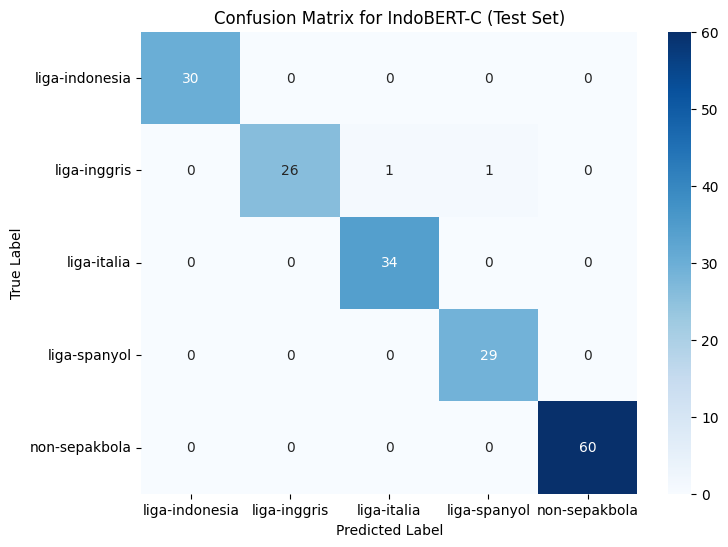


Confusion Matrix Visualization generated.


In [63]:
# print("\n=== Evaluasi IndoBERT-C (Test Set) ===")
# from sklearn.metrics import confusion_matrix, classification_report
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# print(classification_report(y_test, y_pred_c, target_names=label_encoder.classes_, digits=4))

# # --- LANGKAH 1: Hitung Confusion Matrix ---
# cm = confusion_matrix(y_test, y_pred_c)

# # --- LANGKAH 2: Dapatkan Nama Kelas ---
# class_names = label_encoder.classes_

# # --- LANGKAH 3: Visualisasi Confusion Matrix ---
# plt.figure(figsize=(8, 6)) # Ukuran plot

# # sns.heatmap untuk membuat visualisasi
# sns.heatmap(cm,
#             annot=True,        # Menampilkan angka di dalam sel
#             fmt='d',           # Format angka sebagai integer
#             cmap='Blues',      # Skema warna
#             xticklabels=class_names, # Label di sumbu X (predicted)
#             yticklabels=class_names) # Label di sumbu Y (true)

# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for IndoBERT-C (Test Set)')
# plt.show()

# print("\nConfusion Matrix Visualization generated.")

In [56]:
from sklearn.metrics import accuracy_score, f1_score

indobert_a_acc = accuracy_score(y_test, y_pred_a)
indobert_a_f1 = f1_score(y_test, y_pred_a, average='macro')
indobert_b_acc = accuracy_score(y_test, y_pred_b)
indobert_b_f1 = f1_score(y_test, y_pred_b, average='macro')
indobert_c_acc = accuracy_score(y_test, y_pred_c)
indobert_c_f1 = f1_score(y_test, y_pred_c, average='macro')

summary_data = [
    ["IndoBERT-A", "1e-5", "3", indobert_a_acc, indobert_a_f1],
    ["IndoBERT-B", "3e-5", "5", indobert_b_acc, indobert_b_f1],
    ["IndoBERT-C", "5e-5", "7", indobert_c_acc, indobert_c_f1]
]

df_summary = pd.DataFrame(summary_data, columns=["Model", "Learning Rate", "Epochs", "Accuracy", "F1-score"])
print("\n📋 Perbandingan Hasil IndoBERT:")
display(df_summary)



📋 Perbandingan Hasil IndoBERT:


,Model,Learning Rate,Epochs,Accuracy,F1-score
0,IndoBERT-A,1e-5,3,0.98895,0.986304
1,IndoBERT-B,3e-5,5,0.98895,0.986304
2,IndoBERT-C,5e-5,7,0.98895,0.986304


📊 Perbandingan Akhir Semua Model:


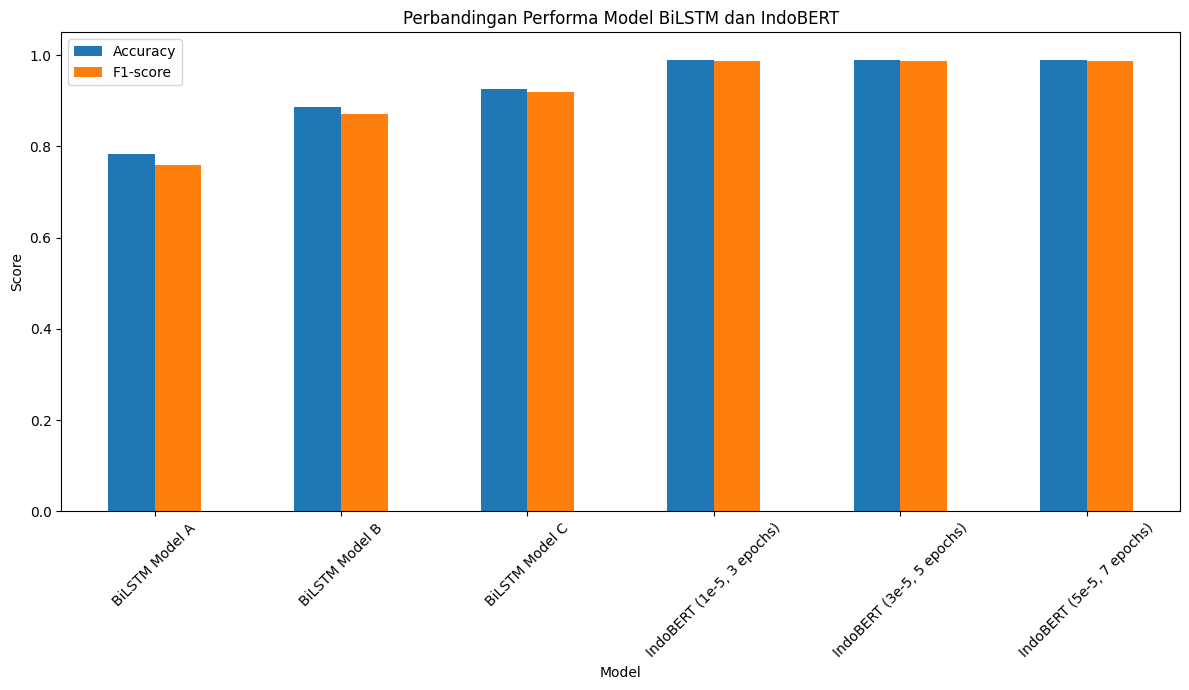

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# === Kumpulkan semua hasil dari variabel yang sudah ada ===
comparison_data = {
    "Model": [
        "BiLSTM Model A",
        "BiLSTM Model B",
        "BiLSTM Model C",
        "IndoBERT (1e-5, 3 epochs)",
        "IndoBERT (3e-5, 5 epochs)",
        "IndoBERT (5e-5, 7 epochs)"
    ],
    "Accuracy": [
        bilstm_a_acc,
        bilstm_b_acc,
        bilstm_c_acc,
        indobert_a_acc,
        indobert_b_acc,
        indobert_c_acc,
        
    ],
    "F1-score": [
        bilstm_a_f1,
        bilstm_b_f1,
        bilstm_c_f1,
        indobert_a_f1,
        indobert_b_f1,
        indobert_c_f1
    ]
}

df_final = pd.DataFrame(comparison_data)
print("📊 Perbandingan Akhir Semua Model:")
# display(df_final)

# # === Visualisasi ===
# plt.figure(figsize=(8,5))
# x = range(len(df_final))
# plt.bar(x, df_final['Accuracy'], alpha=0.6, label='Accuracy')
# plt.bar(x, df_final['F1-score'], alpha=0.6, label='F1-score')
# plt.xticks(x, df_final['Model'], rotation=90, ha='center')
# plt.ylim(0.0, 1.0)
# plt.ylabel('Score')
# plt.title('Perbandingan Kinerja BiLSTM dan IndoBERT')
# plt.legend(loc='lower right')
# plt.tight_layout()
# plt.show()

ax = df_final.set_index('Model').plot(
    kind='bar', 
    figsize=(12, 7), 
    rot=45,  # Rotasi label
    title='Perbandingan Performa Model BiLSTM dan IndoBERT'
)

ax.set_ylabel('Score')
ax.set_ylim(0.0, 1.05)
plt.tight_layout()
plt.show()
# ----------------------------

📊 Data Metrik Lengkap (Akurasi & F1-Score Macro Avg):
| Model      | Data Set   |   Accuracy |   F1-Score (Macro) |
|:-----------|:-----------|-----------:|-------------------:|
| BiLSTM-A   | Train      |     0.8813 |             0.8689 |
| BiLSTM-A   | Valid      |     0.797  |             0.7682 |
| BiLSTM-A   | Test       |     0.761  |             0.7305 |
| BiLSTM-B   | Train      |     0.9581 |             0.9551 |
| BiLSTM-B   | Valid      |     0.8339 |             0.8135 |
| BiLSTM-B   | Test       |     0.8456 |             0.8253 |
| BiLSTM-C   | Train      |     0.9953 |             0.9951 |
| BiLSTM-C   | Valid      |     0.9483 |             0.9436 |
| BiLSTM-C   | Test       |     0.9301 |             0.9266 |
| IndoBERT-A | Train      |     0.9972 |             0.997  |
| IndoBERT-A | Valid      |     0.989  |             0.9864 |
| IndoBERT-A | Test       |     0.989  |             0.9863 |
| IndoBERT-B | Train      |     0.9979 |             0.9977 |
| IndoBERT-B | V

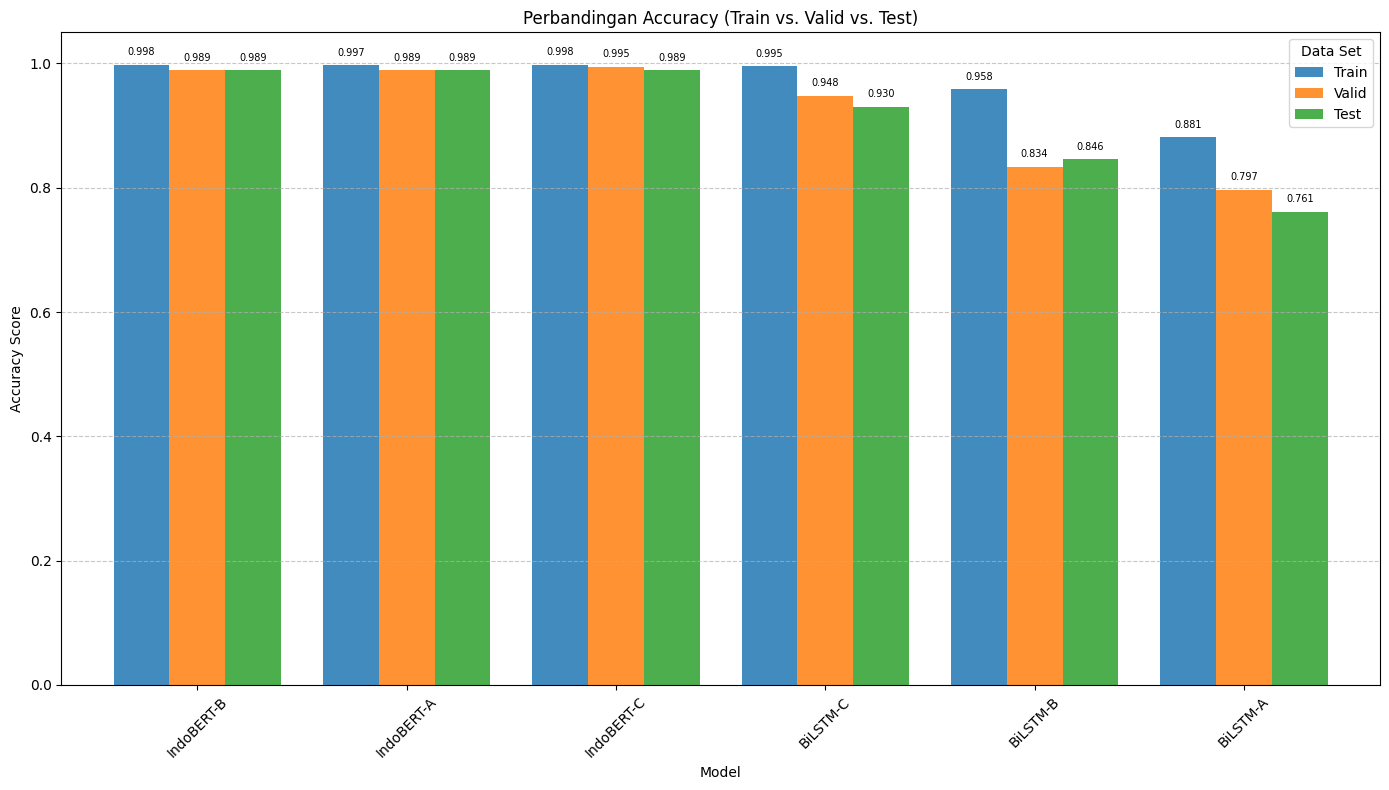

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Langkah 1: Ekstrak Data (Train, Valid, Test untuk Acc & F1) ---
# (Saya mengambil semua data 'accuracy' dan 'macro avg f1-score' dari log Anda)

data = {
    'Model': [
        'BiLSTM-A', 'BiLSTM-A', 'BiLSTM-A',
        'BiLSTM-B', 'BiLSTM-B', 'BiLSTM-B',
        'BiLSTM-C', 'BiLSTM-C', 'BiLSTM-C',
        'IndoBERT-A', 'IndoBERT-A', 'IndoBERT-A',
        'IndoBERT-B', 'IndoBERT-B', 'IndoBERT-B',
        'IndoBERT-C', 'IndoBERT-C', 'IndoBERT-C'
    ],
    'Data Set': [
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test'
    ],
    'Accuracy': [
        0.8813, 0.7970, 0.7610,  # BiLSTM-A
        0.9581, 0.8339, 0.8456,  # BiLSTM-B
        0.9953, 0.9483, 0.9301,  # BiLSTM-C
        0.9972, 0.9890, 0.9890,  # IndoBERT-A
        0.9979, 0.9890, 0.9890,  # IndoBERT-B
        0.9979, 0.9945, 0.9890   # IndoBERT-C
    ],
    'F1-Score (Macro)': [
        0.8689, 0.7682, 0.7305,  # BiLSTM-A
        0.9551, 0.8135, 0.8253,  # BiLSTM-B
        0.9951, 0.9436, 0.9266,  # BiLSTM-C
        0.9970, 0.9864, 0.9863,  # IndoBERT-A
        0.9977, 0.9864, 0.9863,  # IndoBERT-B
        0.9977, 0.9937, 0.9863   # IndoBERT-C
    ]
}

df_all_metrics = pd.DataFrame(data)

print("📊 Data Metrik Lengkap (Akurasi & F1-Score Macro Avg):")
print(df_all_metrics.to_markdown(index=False))

# --- Fungsi Helper untuk Plotting ---
def plot_metric_comparison(df, metric_name):
    """Membuat plot perbandingan Train/Valid/Test untuk satu metrik."""
    
    # Pivot data untuk plotting
    df_pivot = df.pivot(index='Model', columns='Data Set', values=metric_name)
    
    # Atur ulang urutan kolom agar logis
    df_pivot = df_pivot[['Train', 'Valid', 'Test']]
    
    # Urutkan berdasarkan performa Test Set untuk plot yang lebih rapi
    df_pivot = df_pivot.sort_values(by='Test', ascending=False)
    
    # Plot
    ax = df_pivot.plot(
        kind='bar',
        figsize=(14, 8),
        rot=45,
        title=f'Perbandingan {metric_name} (Train vs. Valid vs. Test)',
        alpha=0.85,
        width=0.8 # Lebar bar
    )
    
    ax.set_ylabel(f'{metric_name} Score')
    ax.set_xlabel('Model')
    ax.set_ylim(0.0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title='Data Set')
    
    # Tambahkan label angka
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=7)

    plt.tight_layout()
    plt.show()

# --- Langkah 2: Buat Dua Plot Terpisah ---

# Plot 1: Accuracy
print("\nMenampilkan Plot 1: Accuracy...")
plot_metric_comparison(df_all_metrics, 'Accuracy')



⚠️ Data untuk :
| Model      | Data Set   |   Accuracy |
|:-----------|:-----------|-----------:|
| BiLSTM-A   | Train      |     0.8813 |
| BiLSTM-A   | Valid      |     0.797  |
| BiLSTM-A   | Test       |     0.761  |
| BiLSTM-B   | Train      |     0.9581 |
| BiLSTM-B   | Valid      |     0.8339 |
| BiLSTM-B   | Test       |     0.8456 |
| BiLSTM-C   | Train      |     0.9953 |
| BiLSTM-C   | Valid      |     0.9483 |
| BiLSTM-C   | Test       |     0.9301 |
| IndoBERT-A | Train      |     0.9972 |
| IndoBERT-A | Valid      |     0.989  |
| IndoBERT-A | Test       |     0.989  |
| IndoBERT-B | Train      |     0.9979 |
| IndoBERT-B | Valid      |     0.989  |
| IndoBERT-B | Test       |     0.989  |
| IndoBERT-C | Train      |     0.9979 |
| IndoBERT-C | Valid      |     0.9945 |
| IndoBERT-C | Test       |     0.989  |

Data yang di-pivot untuk plotting:
| Model      |   Train |   Valid |   Test |
|:-----------|--------:|--------:|-------:|
| BiLSTM-A   |  0.8813 |  0.797  | 0.76

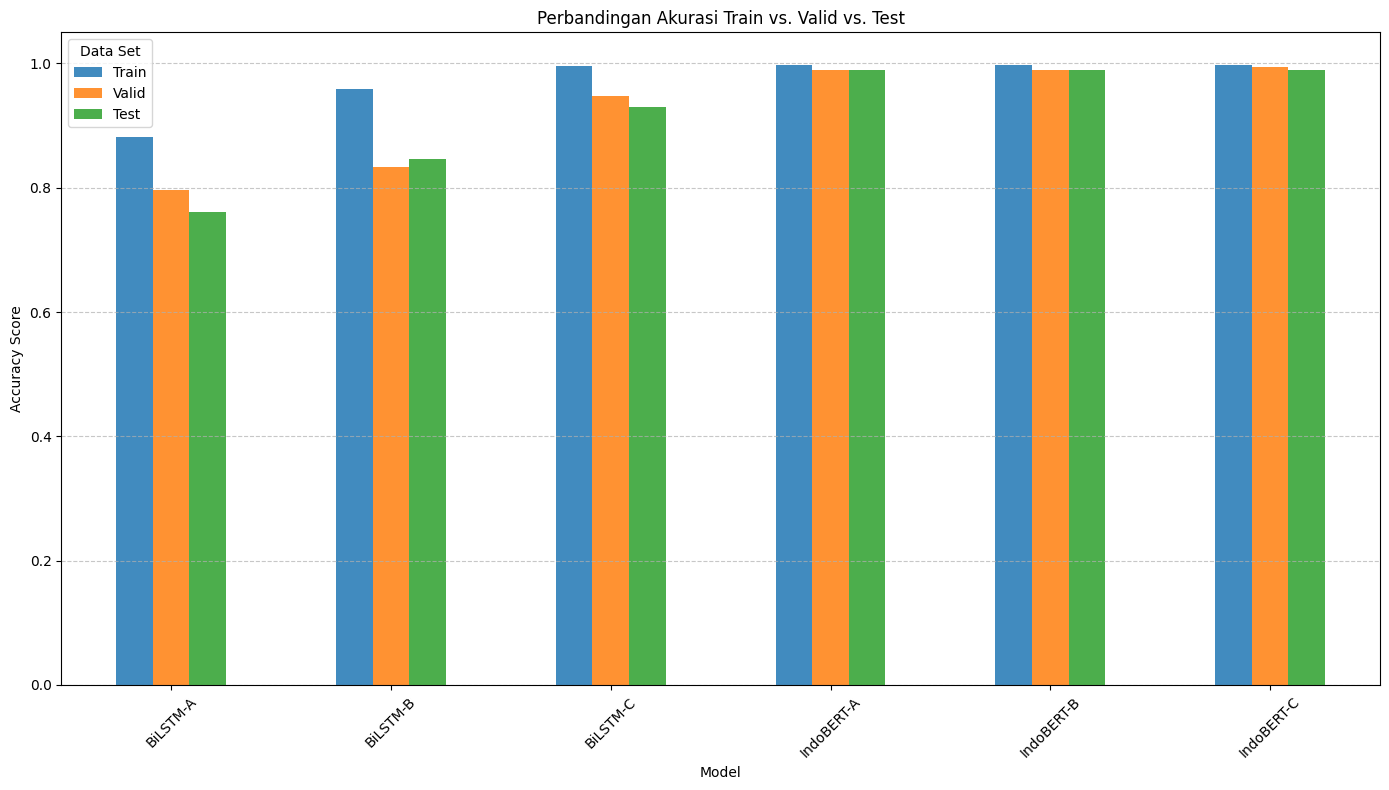

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Langkah 1: Ekstrak Data Train/Valid/Test ---
# (Saya mengambil angka 'accuracy' dari semua laporan Anda)

data_overfit = {
    'Model': [
        'BiLSTM-A', 'BiLSTM-A', 'BiLSTM-A',
        'BiLSTM-B', 'BiLSTM-B', 'BiLSTM-B',
        'BiLSTM-C', 'BiLSTM-C', 'BiLSTM-C',
        'IndoBERT-A', 'IndoBERT-A', 'IndoBERT-A',
        'IndoBERT-B', 'IndoBERT-B', 'IndoBERT-B',
        'IndoBERT-C', 'IndoBERT-C', 'IndoBERT-C'
    ],
    'Data Set': [
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test'
    ],
    'Accuracy': [
        # BiLSTM-A
        0.8813, 0.7970, 0.7610,
        # BiLSTM-B
        0.9581, 0.8339, 0.8456, # (Test sedikit lebih baik dari Valid, menarik)
        # BiLSTM-C
        0.9953, 0.9483, 0.9301,
        # IndoBERT-A
        0.9972, 0.9890, 0.9890,
        # IndoBERT-B
        0.9979, 0.9890, 0.9890,
        # IndoBERT-C
        0.9979, 0.9945, 0.9890
    ]
}

df_overfit = pd.DataFrame(data_overfit)

print("\n⚠️ Data untuk :")
print(df_overfit.to_markdown(index=False))

# --- Langkah 2: Visualisasi (Grouped Bar Chart) ---
# Kita perlu mengubah format data (pivot) agar mudah di-plot
df_pivot = df_overfit.pivot(index='Model', columns='Data Set', values='Accuracy')

# Atur ulang urutan kolom agar logis
df_pivot = df_pivot[['Train', 'Valid', 'Test']]

print("\nData yang di-pivot untuk plotting:")
print(df_pivot.to_markdown())

# Plot
ax = df_pivot.plot(
    kind='bar',
    figsize=(14, 8),
    rot=45,
    title='Perbandingan Akurasi Train vs. Valid vs. Test',
    alpha=0.85
)

ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Model')
ax.set_ylim(0.0, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title='Data Set')

plt.tight_layout()
plt.show()

📊 Data Metrik Lengkap (Macro Avg):
| Model      | Data Set   |   Precision |   Recall |   F1-Score |
|:-----------|:-----------|------------:|---------:|-----------:|
| BiLSTM-A   | Train      |      0.8724 |   0.8722 |     0.8689 |
| BiLSTM-A   | Valid      |      0.7778 |   0.7765 |     0.7682 |
| BiLSTM-A   | Test       |      0.7384 |   0.742  |     0.7305 |
| BiLSTM-B   | Train      |      0.959  |   0.9545 |     0.9551 |
| BiLSTM-B   | Valid      |      0.8347 |   0.8153 |     0.8135 |
| BiLSTM-B   | Test       |      0.8387 |   0.8265 |     0.8253 |
| BiLSTM-C   | Train      |      0.9953 |   0.9948 |     0.9951 |
| BiLSTM-C   | Valid      |      0.9462 |   0.9424 |     0.9436 |
| BiLSTM-C   | Test       |      0.9417 |   0.9192 |     0.9266 |
| IndoBERT-A | Train      |      0.997  |   0.997  |     0.997  |
| IndoBERT-A | Valid      |      0.9855 |   0.9875 |     0.9864 |
| IndoBERT-A | Test       |      0.9876 |   0.9857 |     0.9863 |
| IndoBERT-B | Train      |      0.9977 |

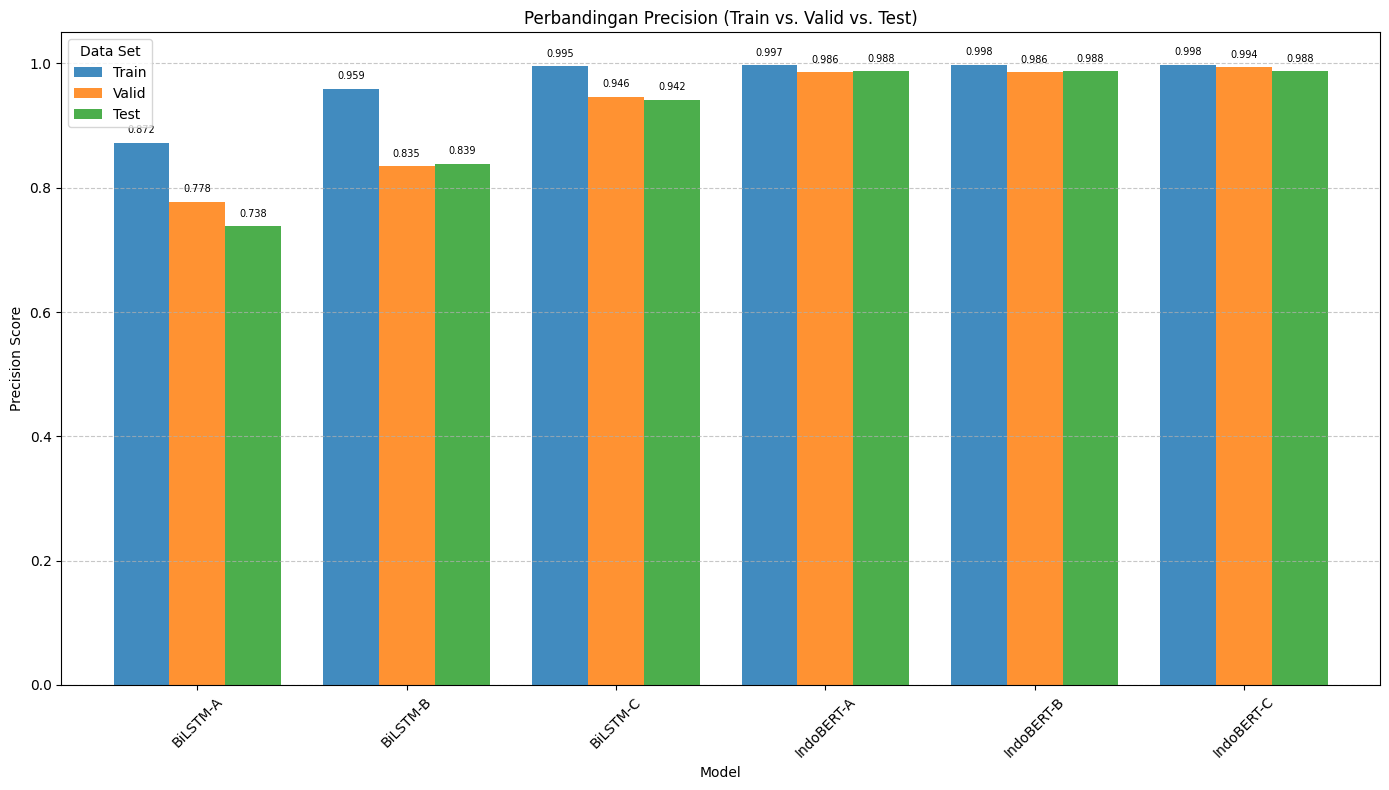


Menampilkan Plot 2: Recall...


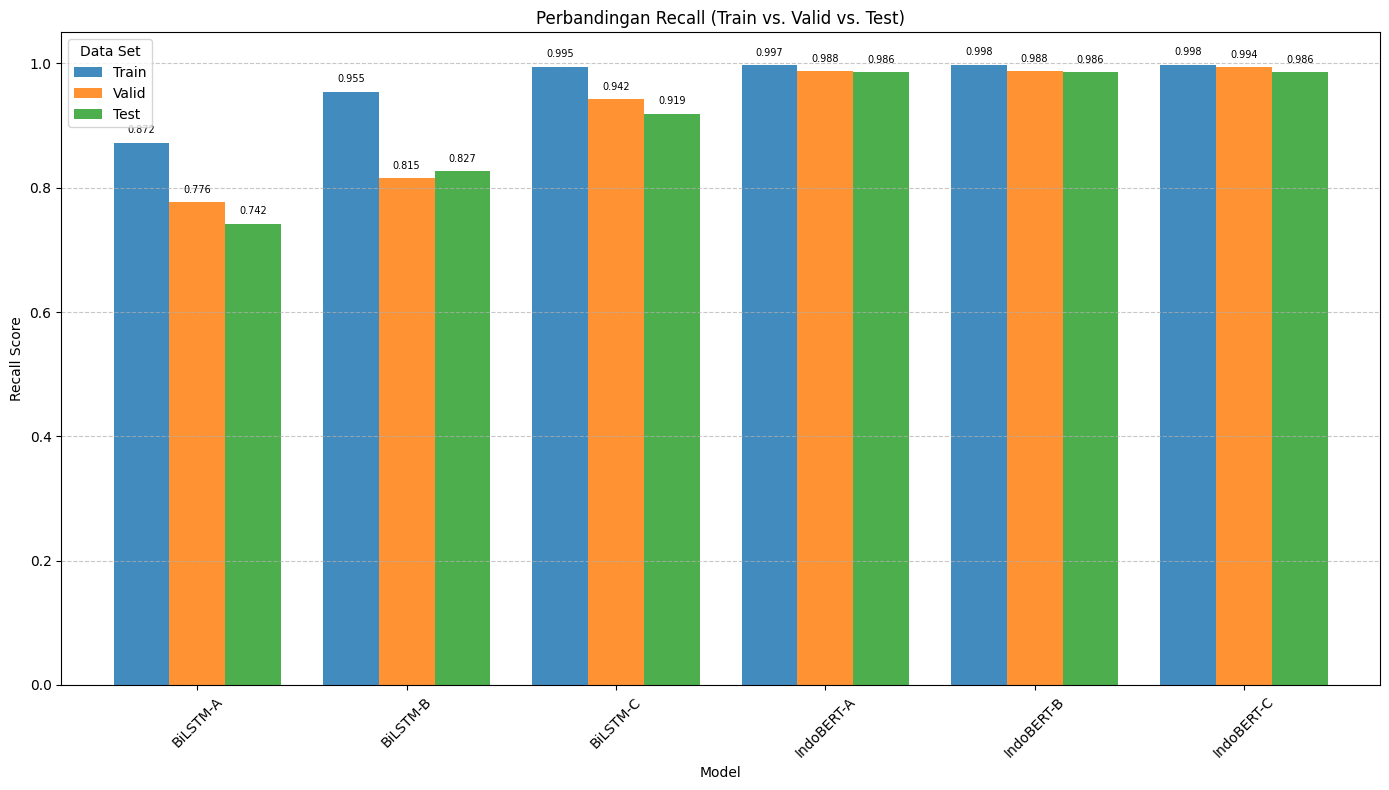


Menampilkan Plot 3: F1-Score...


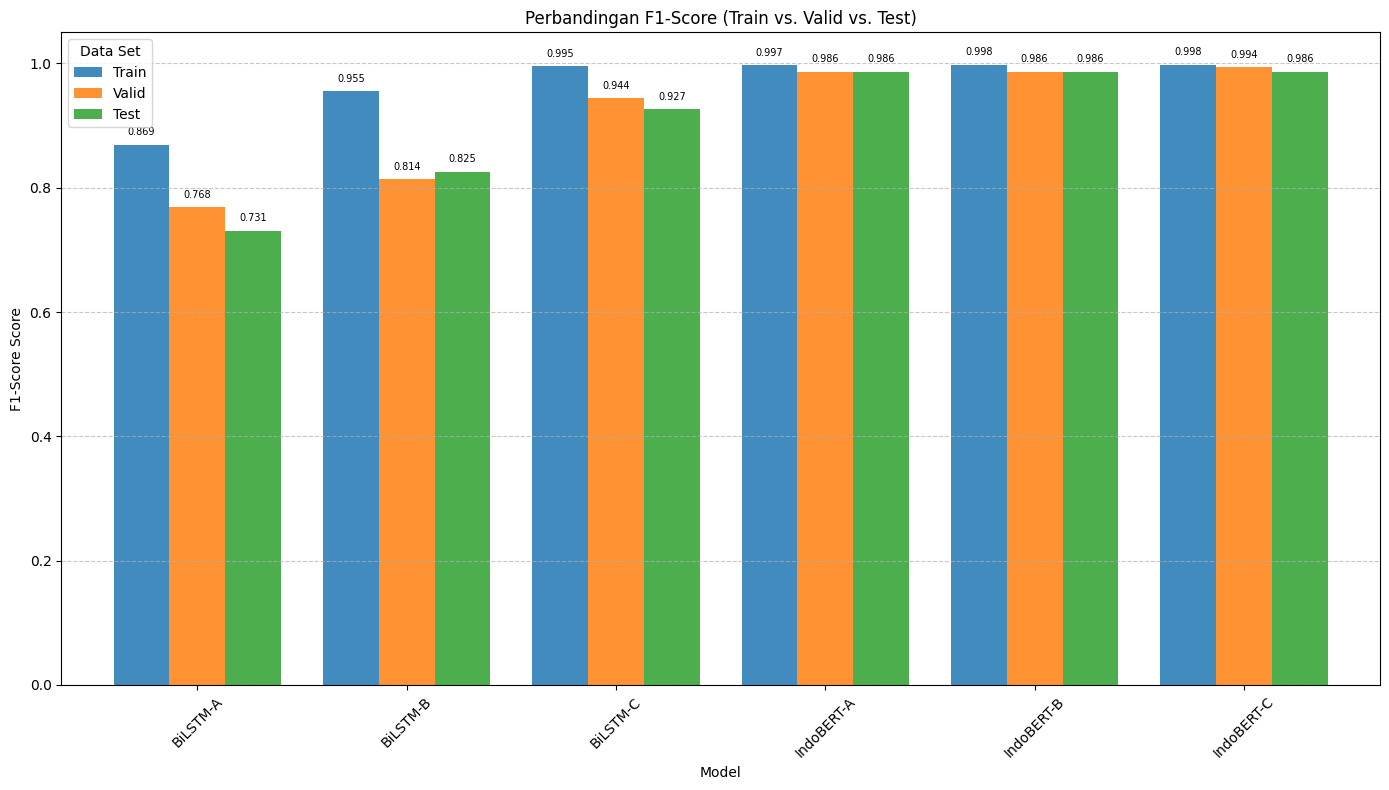

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Langkah 1: Ekstrak Data (Macro Avg dari SEMUA Laporan) ---
# Saya telah mengambil semua data 'macro avg' dari log Anda.

data = {
    'Model': [
        'BiLSTM-A', 'BiLSTM-A', 'BiLSTM-A',
        'BiLSTM-B', 'BiLSTM-B', 'BiLSTM-B',
        'BiLSTM-C', 'BiLSTM-C', 'BiLSTM-C',
        'IndoBERT-A', 'IndoBERT-A', 'IndoBERT-A',
        'IndoBERT-B', 'IndoBERT-B', 'IndoBERT-B',
        'IndoBERT-C', 'IndoBERT-C', 'IndoBERT-C'
    ],
    'Data Set': [
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test'
    ],
    'Precision': [
        0.8724, 0.7778, 0.7384,  # BiLSTM-A
        0.9590, 0.8347, 0.8387,  # BiLSTM-B
        0.9953, 0.9462, 0.9417,  # BiLSTM-C
        0.9970, 0.9855, 0.9876,  # IndoBERT-A
        0.9977, 0.9855, 0.9876,  # IndoBERT-B
        0.9977, 0.9938, 0.9876   # IndoBERT-C
    ],
    'Recall': [
        0.8722, 0.7765, 0.7420,  # BiLSTM-A
        0.9545, 0.8153, 0.8265,  # BiLSTM-B
        0.9948, 0.9424, 0.9192,  # BiLSTM-C
        0.9970, 0.9875, 0.9857,  # IndoBERT-A
        0.9977, 0.9875, 0.9857,  # IndoBERT-B
        0.9977, 0.9939, 0.9857   # IndoBERT-C
    ],
    'F1-Score': [
        0.8689, 0.7682, 0.7305,  # BiLSTM-A
        0.9551, 0.8135, 0.8253,  # BiLSTM-B
        0.9951, 0.9436, 0.9266,  # BiLSTM-C
        0.9970, 0.9864, 0.9863,  # IndoBERT-A
        0.9977, 0.9864, 0.9863,  # IndoBERT-B
        0.9977, 0.9937, 0.9863   # IndoBERT-C
    ]
}

df_all_metrics = pd.DataFrame(data)

print("📊 Data Metrik Lengkap (Macro Avg):")
print(df_all_metrics.to_markdown(index=False))

# --- Fungsi Helper untuk Plotting ---
def plot_metric_comparison(df, metric_name):
    """Membuat plot perbandingan Train/Valid/Test untuk satu metrik."""
    
    # Pivot data untuk plotting
    df_pivot = df.pivot(index='Model', columns='Data Set', values=metric_name)
    
    # Atur ulang urutan kolom agar logis
    df_pivot = df_pivot[['Train', 'Valid', 'Test']]
    
    # Plot
    ax = df_pivot.plot(
        kind='bar',
        figsize=(14, 8),
        rot=45,
        title=f'Perbandingan {metric_name} (Train vs. Valid vs. Test)',
        alpha=0.85,
        width=0.8 # Lebar bar
    )
    
    ax.set_ylabel(f'{metric_name} Score')
    ax.set_xlabel('Model')
    ax.set_ylim(0.0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title='Data Set')
    
    # Tambahkan label angka
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=7)

    plt.tight_layout()
    plt.show()

# --- Langkah 2: Buat Tiga Plot Terpisah ---

# Plot 1: Precision
print("\nMenampilkan Plot 1: Precision...")
plot_metric_comparison(df_all_metrics, 'Precision')

# Plot 2: Recall
print("\nMenampilkan Plot 2: Recall...")
plot_metric_comparison(df_all_metrics, 'Recall')

# Plot 3: F1-Score
print("\nMenampilkan Plot 3: F1-Score...")
plot_metric_comparison(df_all_metrics, 'F1-Score')

# Train Model 2

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
tqdm.pandas()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [42]:
df_train = pd.read_csv(os.path.join(dataset_path, 'preprocessed-dataset.csv'))
X = df_train['clean_text'].astype(str).values
y = df_train['label'].values


# === Tokenisasi sederhana
def tokenize(text):
    return text.split()

tokenized_texts = [tokenize(t) for t in X]

# === Bangun vocabulary (top 20.000 kata)
word_counts = Counter(word for tokens in tokenized_texts for word in tokens)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common(20000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# === Konversi kata → indeks
def encode_text(tokens, vocab, max_len=200):
    encoded = [vocab.get(word, vocab['<UNK>']) for word in tokens]
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded


In [43]:
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [44]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # dua arah
        hidden = self.dropout(hidden)
        return self.fc(hidden)


In [47]:
def train_with_validation(model, train_loader, valid_loader, optimizer, criterion, device, num_epochs=6):
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = output.argmax(dim=1)
            total_correct += (preds == y_batch).sum().item()
            total_samples += y_batch.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = total_correct / total_samples

        # === Validasi
        model.eval()
        valid_loss, valid_correct, valid_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                valid_loss += loss.item()
                preds = output.argmax(dim=1)
                valid_correct += (preds == y_batch).sum().item()
                valid_samples += y_batch.size(0)

        valid_loss /= len(valid_loader)
        valid_acc = valid_correct / valid_samples

        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['train_acc'].append(train_acc)
        history['valid_acc'].append(valid_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {valid_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {valid_acc:.4f}")

    return history

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    """
    Membuat visualisasi Confusion Matrix menggunakan Matplotlib.
    (Versi ini sudah diperbaiki untuk menangani data yang tidak seimbang)
    """
    
    # === PERBAIKAN DI SINI ===
    # 1. Tentukan label numerik berdasarkan nama kelas
    #    (misal: [0, 1] jika class_names punya 2 item)
    labels_num = list(range(len(class_names)))
    
    # 2. Berikan 'labels=labels_num' ke confusion_matrix
    #    Ini memaksa sklearn membuat matriks N-x-N (misal 2x2)
    #    bahkan jika data Anda hanya berisi satu kelas.
    cm = confusion_matrix(y_true, y_pred, labels=labels_num)
    # =========================
    
    n_classes = len(class_names)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Tampilkan matriks sebagai gambar (heatmap)
    cax = ax.imshow(cm, cmap='Blues')
    
    # Tambahkan color bar
    fig.colorbar(cax)
    
    # Atur label sumbu X (Predicted)
    ax.set_xticks(np.arange(n_classes))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_xlabel('Predicted Label')
    
    # Atur label sumbu Y (True)
    ax.set_yticks(np.arange(n_classes))
    ax.set_yticklabels(class_names)
    ax.set_ylabel('True Label')
    
    # Set judul
    ax.set_title(title)
    
    # Tambahkan anotasi (angka) di dalam sel
    threshold = cm.max() / 2.
    # Cek agar tidak error jika cm.max() adalah 0
    if threshold == 0:
        threshold = 1 
        
    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(j, i, f'{cm[i, j]}', # Teks adalah nilai dari cm[i, j]
                    ha='center',        # Rata tengah horizontal
                    va='center',        # Rata tengah vertikal
                    color='white' if cm[i, j] > threshold else 'black')
            
    plt.tight_layout() # Merapikan layout
    plt.show()

# def plot_confusion_matrix(y_true, y_pred, class_names, title):
#     """
#     Membuat visualisasi Confusion Matrix menggunakan Matplotlib.
#     """
#     cm = confusion_matrix(y_true, y_pred)
#     n_classes = len(class_names)
    
#     fig, ax = plt.subplots(figsize=(8, 6))
    
#     # Tampilkan matriks sebagai gambar (heatmap)
#     cax = ax.imshow(cm, cmap='Blues')
    
#     # Tambahkan color bar
#     fig.colorbar(cax)
    
#     # Atur label sumbu X (Predicted)
#     ax.set_xticks(np.arange(n_classes))
#     ax.set_xticklabels(class_names, rotation=45, ha="right")
#     ax.set_xlabel('Predicted Label')
    
#     # Atur label sumbu Y (True)
#     ax.set_yticks(np.arange(n_classes))
#     ax.set_yticklabels(class_names)
#     ax.set_ylabel('True Label')
    
#     # Set judul
#     ax.set_title(title)
    
#     # Tambahkan anotasi (angka) di dalam sel
#     threshold = cm.max() / 2.  # Ambang batas untuk mengubah warna teks
#     for i in range(n_classes):
#         for j in range(n_classes):
#             ax.text(j, i, f'{cm[i, j]}', # Teks adalah nilai dari cm[i, j]
#                     ha='center',        # Rata tengah horizontal
#                     va='center',        # Rata tengah vertikal
#                     # Ubah warna teks menjadi putih untuk sel gelap
#                     color='white' if cm[i, j] > threshold else 'black')
            
#     plt.tight_layout() # Merapikan layout
#     plt.show()

def evaluate_model(model, test_loader, device, target_names=None):
    """
    Versi yang diperbaiki: Menerima 'target_names' sebagai list nama, 
    dan tetap menyertakan perbaikan 'labels' untuk ValueError.
    """
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)

            if hasattr(output, "logits"):
                output = output.logits
                
            pred = output.argmax(dim=1)
            preds.extend(pred.cpu().numpy())
            labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    # --- LOGIKA NAMA YANG DIPERBAIKI ---
    if target_names is None:
        # Jika tidak ada nama, buat nama default
        print("Peringatan: target_names=None, menggunakan nama default.")
        unique_labels = sorted(list(set(labels)))
        class_names = [f"Class {i}" for i in unique_labels]
    else:
        # Jika ada nama, gunakan nama itu
        class_names = target_names 
    # ------------------------------------

    # --- PERBAIKAN UNTUK ValueError (dari error sebelumnya) ---
    # Buat daftar label numerik berdasarkan jumlah nama target
    report_labels = list(range(len(class_names)))
    # -----------------------------------------------

    report = classification_report(labels, preds, 
                                   target_names=class_names, 
                                   labels=report_labels,  # <-- Ini memperbaiki ValueError
                                   digits=4, 
                                   zero_division=0)
    
    # Kembalikan labels & preds untuk plotting
    return report, acc, f1, labels, preds

In [48]:
# === Stage 1: Binary (Sepakbola vs Non-sepakbola)
df_stage1 = df_train.copy()
df_stage1['is_sepakbola'] = df_stage1['label'].apply(lambda x: 0 if x == 'non-sepakbola' else 1)

X1 = df_stage1['clean_text'].astype(str).values
y1 = df_stage1['is_sepakbola'].values
encoded_texts_1 = np.array([encode_text(t.split(), vocab) for t in X1])


X1_train, X1_temp, y1_train, y1_temp = train_test_split(encoded_texts_1, y1, test_size=0.2, random_state=42)
X1_valid, X1_test, y1_valid, y1_test = train_test_split(X1_temp, y1_temp, test_size=0.5, random_state=42)

train_loader1 = DataLoader(NewsDataset(torch.tensor(X1_train), torch.tensor(y1_train)), batch_size=32, shuffle=True)
valid_loader1 = DataLoader(NewsDataset(torch.tensor(X1_valid), torch.tensor(y1_valid)), batch_size=32)
test_loader1  = DataLoader(NewsDataset(torch.tensor(X1_test),  torch.tensor(y1_test)),  batch_size=32)



# === Stage 2: Multiclass (Empat Liga)
df_stage2 = df_stage1[df_stage1['is_sepakbola'] == 1]
X2 = df_stage2['clean_text'].astype(str).values
y2 = df_stage2['label'].values

label_encoder2 = LabelEncoder()
y2_encoded = label_encoder2.fit_transform(y2)
num_classes2 = len(label_encoder2.classes_)
print("Label Stage 2:", label_encoder2.classes_)

encoded_texts_2 = np.array([encode_text(t.split(), vocab) for t in X2])

X2_train, X2_temp, y2_train, y2_temp = train_test_split(encoded_texts_2, y2_encoded, test_size=0.2, random_state=42)
X2_valid, X2_test, y2_valid, y2_test = train_test_split(X2_temp, y2_temp, test_size=0.5, random_state=42)

train_loader2 = DataLoader(NewsDataset(torch.tensor(X2_train), torch.tensor(y2_train)), batch_size=32, shuffle=True)
valid_loader2 = DataLoader(NewsDataset(torch.tensor(X2_valid), torch.tensor(y2_valid)), batch_size=32)
test_loader2  = DataLoader(NewsDataset(torch.tensor(X2_test),  torch.tensor(y2_test)),  batch_size=32)

df_stage1.describe()

Label Stage 2: ['liga-indonesia' 'liga-inggris' 'liga-italia' 'liga-spanyol']


,index,is_sepakbola
count,1807.000000,1807.000000
mean,903.000000,0.725512
std,521.780286,0.446379
min,0.000000,0.000000
25%,451.500000,0.000000
50%,903.000000,1.000000
75%,1354.500000,1.000000
max,1806.000000,1.000000


In [ ]:
# =====================================================
# ⚽️ TRAINING BILSTM 2-STAGE
# =====================================================

criterion = nn.CrossEntropyLoss()

# === Stage 1 (Binary)
print("Training (Binary: sepakbola vs non-sepakbola)")

model1_a = BiLSTMModel(len(vocab), 32, 32, 2, 0.5).to(device)
optimizer1_a = optim.Adam(model1_a.parameters(), lr=1e-3)
print("🧠 Stage 1-A (e32, h32)")
history1_a = train_with_validation(model1_a, train_loader1, valid_loader1, optimizer1_a, criterion, device)

model1_b = BiLSTMModel(len(vocab), 64, 64, 2, 0.5).to(device)
optimizer1_b = optim.Adam(model1_b.parameters(), lr=1e-3)
print("\n🧠 Stage 1-B (e64, h64)")
history1_b = train_with_validation(model1_b, train_loader1, valid_loader1, optimizer1_b, criterion, device)

model1_c = BiLSTMModel(len(vocab), 128, 128, 2, 0.5).to(device)
optimizer1_c = optim.Adam(model1_c.parameters(), lr=1e-3)
print("\n🧠 Stage 1-B (e128, h128")
history1_c= train_with_validation(model1_c, train_loader1, valid_loader1, optimizer1_c, criterion, device)

# === Stage 2 (Multiclass)
print("\n⚽ Stage 2 Training (Empat liga)")

model2_a = BiLSTMModel(len(vocab), 32, 32, num_classes2, 0.5).to(device)
optimizer2_a = optim.Adam(model2_a.parameters(), lr=1e-3)
print("🧠 Stage 2-A (e32, h32)")
history2_a =train_with_validation(model2_a, train_loader2, valid_loader2, optimizer2_a, criterion, device)

model2_b = BiLSTMModel(len(vocab), 64, 64, num_classes2, 0.5).to(device)
optimizer2_b = optim.Adam(model2_b.parameters(), lr=1e-3)
print("\n🧠 Stage 2-B (e64, h64)")
history2_b = train_with_validation(model2_b, train_loader2, valid_loader2, optimizer2_b, criterion, device)


model2_c = BiLSTMModel(len(vocab), 128, 128, num_classes2, 0.5).to(device)
optimizer2_c = optim.Adam(model2_c.parameters(), lr=1e-3)
print("\n🧠 Stage 2-C (e128, h128)")
history2_c = train_with_validation(model2_c, train_loader2, valid_loader2, optimizer2_c, criterion, device)

Training (Binary: sepakbola vs non-sepakbola)
🧠 Stage 1-A (e32, h32)
Epoch 1/6 | Train Loss: 0.5666 | Val Loss: 0.5907 | Train Acc: 0.7426 | Val Acc: 0.7238
Epoch 2/6 | Train Loss: 0.4636 | Val Loss: 0.5502 | Train Acc: 0.8090 | Val Acc: 0.7514
Epoch 3/6 | Train Loss: 0.3579 | Val Loss: 0.5276 | Train Acc: 0.8478 | Val Acc: 0.7569
Epoch 4/6 | Train Loss: 0.2118 | Val Loss: 0.3174 | Train Acc: 0.9059 | Val Acc: 0.8508
Epoch 5/6 | Train Loss: 0.1310 | Val Loss: 0.2616 | Train Acc: 0.9543 | Val Acc: 0.9171
Epoch 6/6 | Train Loss: 0.0948 | Val Loss: 0.1368 | Train Acc: 0.9792 | Val Acc: 0.9724
               precision    recall  f1-score   support

non sepakbola     0.9333    0.9333    0.9333        60
    sepakbola     0.9669    0.9669    0.9669       121

     accuracy                         0.9558       181
    macro avg     0.9501    0.9501    0.9501       181
 weighted avg     0.9558    0.9558    0.9558       181


🧠 Stage 1-B (e64, h64)
Epoch 1/6 | Train Loss: 0.5167 | Val Loss: 0.5

In [50]:
print("======= Memulai Evaluasi Model (Lengkap) =======")

# --- Evaluasi Model 1-A (Sesuai Referensi) ---
print("\n--- Mengevaluasi Model 1-A ---")
report1_at, acc1_at, f1_1at, labels1_at, preds1_at = evaluate_model(model1_a, train_loader1, device, ["non sepakbola", "sepakbola"])
print("Laporan Model 1-A (Train):")
print(report1_at)

report1_av, acc1_av, f1_1av, labels1_av, preds1_av = evaluate_model(model1_a, valid_loader1, device, ["non sepakbola", "sepakbola"])
print("Laporan Model 1-A (Valid):")
print(report1_av)

report1_ats, acc1_ats, f1_1ats, labels1_ats, preds1_ats = evaluate_model(model1_a, test_loader1, device, ["non sepakbola", "sepakbola"])
print("Laporan Model 1-A (Test):")
print(report1_ats)

# --- Evaluasi Model 1-B (Disesuaikan) ---
print("\n--- Mengevaluasi Model 1-B ---")
report1_bt, acc1_bt, f1_1bt, labels1_bt, preds1_bt = evaluate_model(model1_b, train_loader1, device, ["non sepakbola", "sepakbola"])
print("Laporan Model 1-B (Train):")
print(report1_bt)

report1_bv, acc1_bv, f1_1bv, labels1_bv, preds1_bv = evaluate_model(model1_b, valid_loader1, device, ["non sepakbola", "sepakbola"])
print("Laporan Model 1-B (Valid):")
print(report1_bv)

report1_bts, acc1_bts, f1_1bts, labels1_bts, preds1_bts = evaluate_model(model1_b, test_loader1, device, ["non sepakbola", "sepakbola"])
print("Laporan Model 1-B (Test):")
print(report1_bts)

# --- Evaluasi Model 1-C (Disesuaikan) ---
print("\n--- Mengevaluasi Model 1-C ---")
report1_ct, acc1_ct, f1_1ct, labels1_ct, preds1_ct = evaluate_model(model1_c, train_loader1, device, ["non sepakbola", "sepakbola"])
print("Laporan Model 1-C (Train):")
print(report1_ct)

report1_cv, acc1_cv, f1_1cv, labels1_cv, preds1_cv = evaluate_model(model1_c, valid_loader1, device, ["non sepakbola", "sepakbola"])
print("Laporan Model 1-C (Valid):")
print(report1_cv)

report1_cts, acc1_cts, f1_1cts, labels1_cts, preds1_cts = evaluate_model(model1_c, test_loader1, device, ["non sepakbola", "sepakbola"])
print("Laporan Model 1-C (Test):")
print(report1_cts)

print("\n======= Evaluasi Stage 1 Selesai =======")

# --- Evaluasi Model 2-A (Disesuaikan) ---
print("\n--- Mengevaluasi Model 2-A ---")
report2_at, acc2_at, f1_2at, labels2_at, preds2_at = evaluate_model(model2_a, train_loader2, device, label_encoder2.classes_)
print("Laporan Model 2-A (Train):")
print(report2_at)

report2_av, acc2_av, f1_2av, labels2_av, preds2_av = evaluate_model(model2_a, valid_loader2, device, label_encoder2.classes_)
print("Laporan Model 2-A (Valid):")
print(report2_av)

report2_ats, acc2_ats, f1_2ats, labels2_ats, preds2_ats = evaluate_model(model2_a, test_loader2, device, label_encoder2.classes_)
print("Laporan Model 2-A (Test):")
print(report2_ats)

# --- Evaluasi Model 2-B (Disesuaikan) ---
print("\n--- Mengevaluasi Model 2-B ---")
report2_bt, acc2_bt, f1_2bt, labels2_bt, preds2_bt = evaluate_model(model2_b, train_loader2, device, label_encoder2.classes_)
print("Laporan Model 2-B (Train):")
print(report2_bt)

report2_bv, acc2_bv, f1_2bv, labels2_bv, preds2_bv = evaluate_model(model2_b, valid_loader2, device, label_encoder2.classes_)
print("Laporan Model 2-B (Valid):")
print(report2_bv)

report2_bts, acc2_bts, f1_2bts, labels2_bts, preds2_bts = evaluate_model(model2_b, test_loader2, device, label_encoder2.classes_)
print("Laporan Model 2-B (Test):")
print(report2_bts)

# --- Evaluasi Model 2-C (Disesuaikan) ---
print("\n--- Mengevaluasi Model 2-C ---")
report2_ct, acc2_ct, f1_2ct, labels2_ct, preds2_ct = evaluate_model(model2_c, train_loader2, device, label_encoder2.classes_)
print("Laporan Model 2-C (Train):")
print(report2_ct)

report2_cv, acc2_cv, f1_2cv, labels2_cv, preds2_cv = evaluate_model(model2_c, valid_loader2, device, label_encoder2.classes_)
print("Laporan Model 2-C (Valid):")
print(report2_cv)

report2_cts, acc2_cts, f1_2cts, labels2_cts, preds2_cts = evaluate_model(model2_c, test_loader2, device, label_encoder2.classes_)
print("Laporan Model 2-C (Test):")
print(report2_cts)

print("\n======= Evaluasi Stage 2 Selesai =======")

======= Memulai Evaluasi Model (Lengkap) =======

--- Mengevaluasi Model 1-A ---
Laporan Model 1-A (Train):
               precision    recall  f1-score   support

non sepakbola     0.9456    0.9892    0.9669       369
    sepakbola     0.9962    0.9805    0.9883      1076

     accuracy                         0.9827      1445
    macro avg     0.9709    0.9848    0.9776      1445
 weighted avg     0.9833    0.9827    0.9828      1445

Laporan Model 1-A (Valid):
               precision    recall  f1-score   support

non sepakbola     0.9697    0.9552    0.9624        67
    sepakbola     0.9739    0.9825    0.9782       114

     accuracy                         0.9724       181
    macro avg     0.9718    0.9688    0.9703       181
 weighted avg     0.9724    0.9724    0.9723       181

Laporan Model 1-A (Test):
               precision    recall  f1-score   support

non sepakbola     0.9333    0.9333    0.9333        60
    sepakbola     0.9669    0.9669    0.9669       121

     a

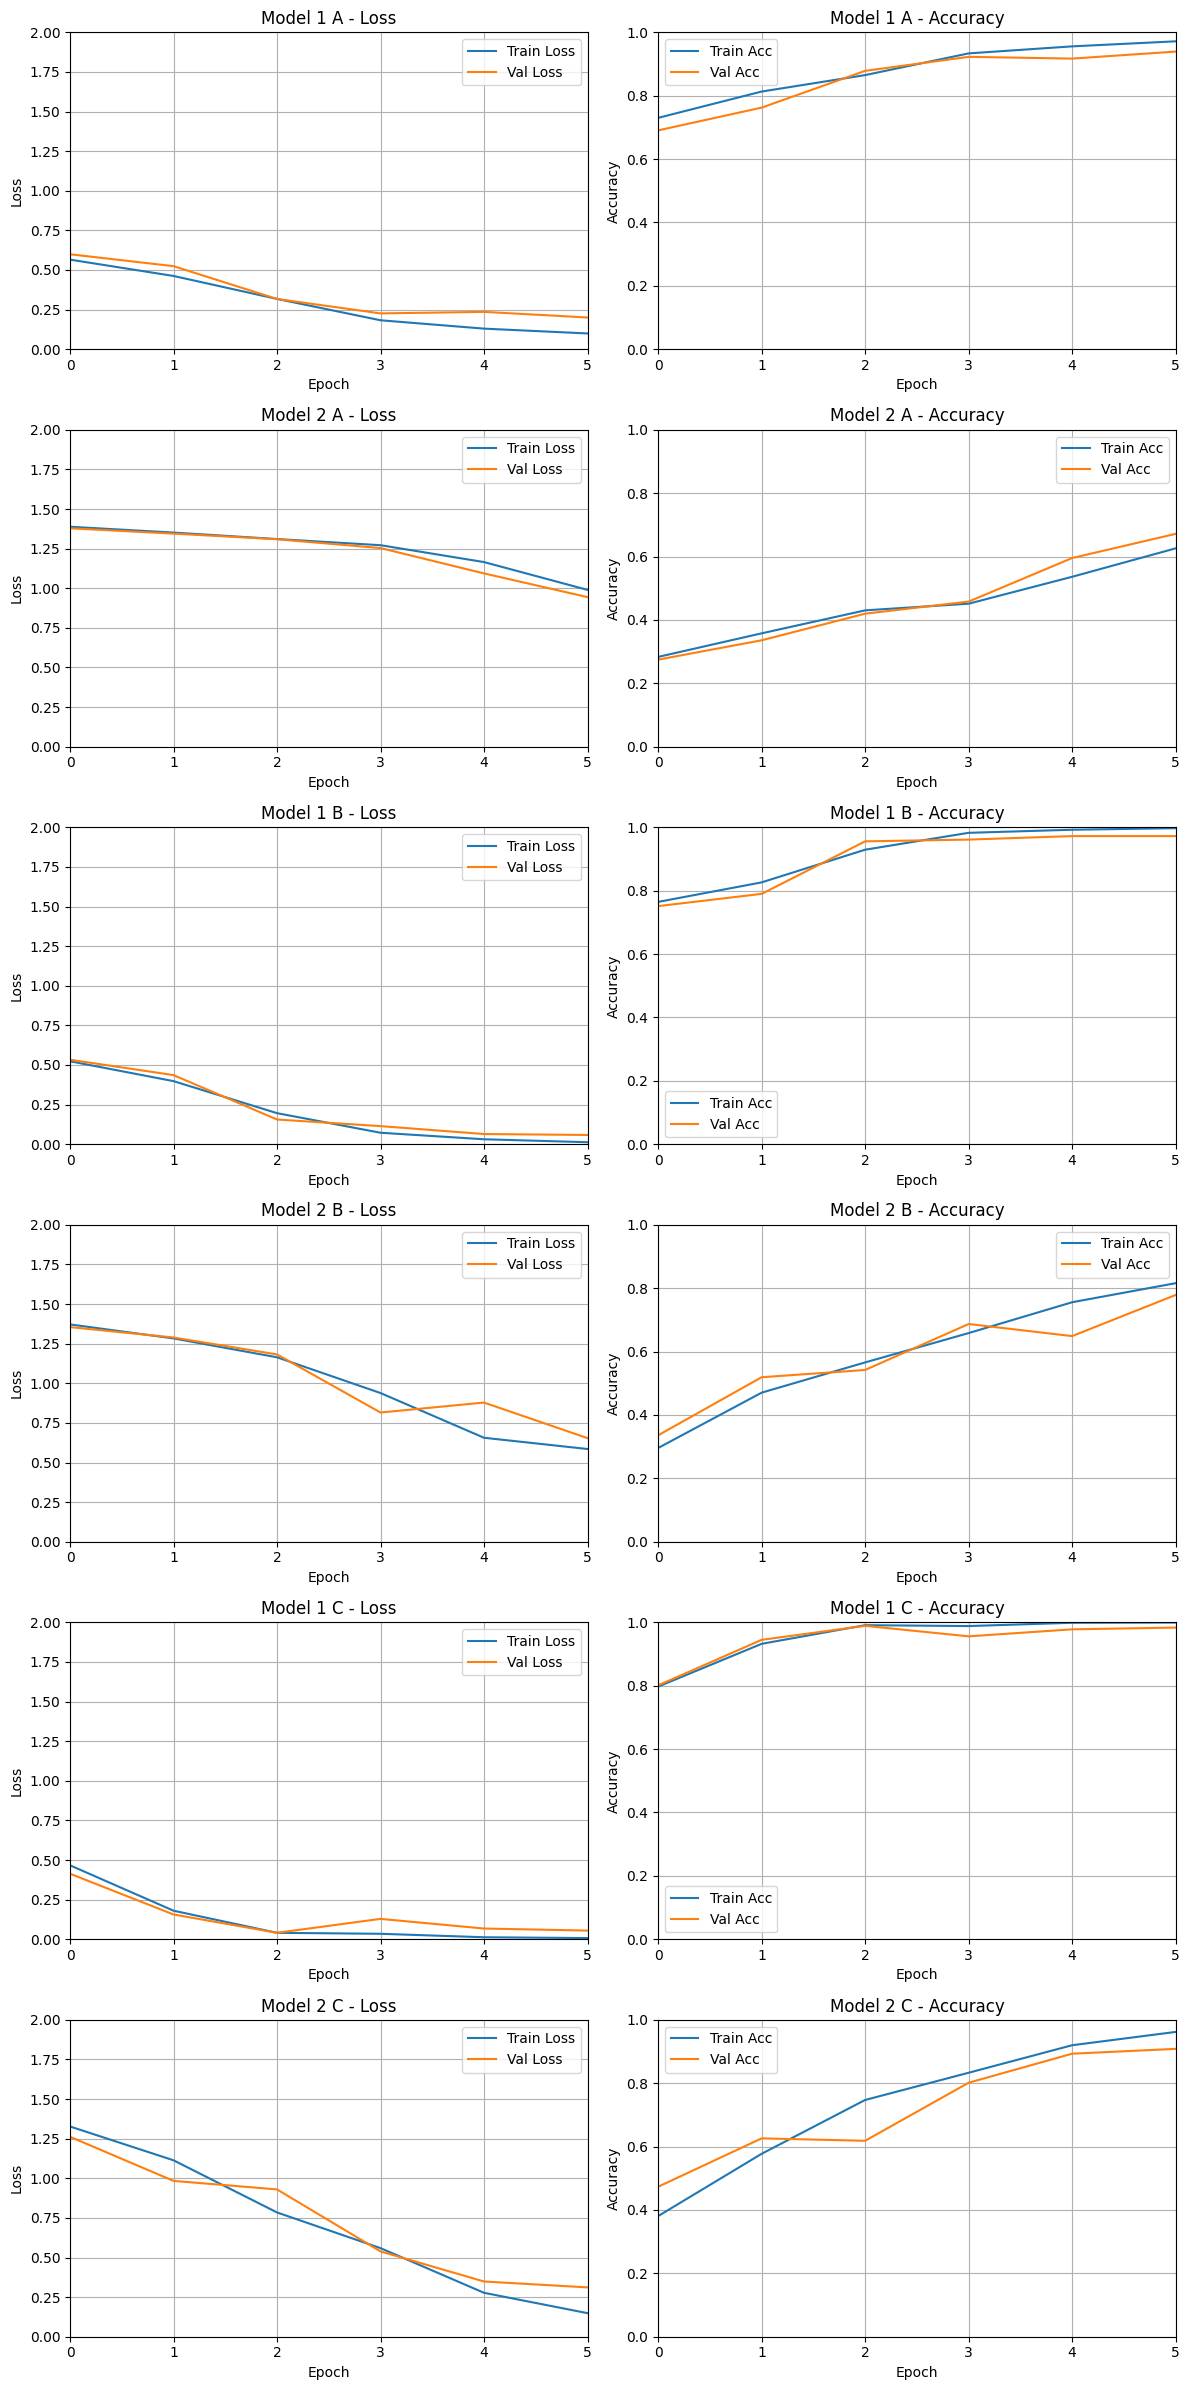

In [144]:
# def plot_history_per_model(history_a, history_b, history_c):

fig, axes = plt.subplots(6, 2, figsize=(12, 24))

# --- Model1 A Loss ---
axes[0, 0].plot(history1_a['train_loss'], label='Train Loss')
axes[0, 0].plot(history1_a['valid_loss'], label='Val Loss')
axes[0, 0].set_title('Model 1 A - Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_xlim(0, 5)
axes[0, 0].set_ylim(0, 2)
axes[0, 0].legend()
axes[0, 0].grid(True)

# --- Model1 A Accuracy ---
axes[0, 1].plot(history1_a['train_acc'], label='Train Acc')
axes[0, 1].plot(history1_a['valid_acc'], label='Val Acc')
axes[0, 1].set_title('Model 1 A - Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_xlim(0, 5)
axes[0, 1].legend()
axes[0, 1].grid(True)

# --- Model2 A Loss ---
axes[1, 0].plot(history2_a['train_loss'], label='Train Loss')
axes[1, 0].plot(history2_a['valid_loss'], label='Val Loss')
axes[1, 0].set_title('Model 2 A - Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xlim(0, 5)
axes[1, 0].set_ylim(0, 2)
axes[1, 0].legend()
axes[1, 0].grid(True)

# --- Model2 A Accuracy ---
axes[1, 1].plot(history2_a['train_acc'], label='Train Acc')
axes[1, 1].plot(history2_a['valid_acc'], label='Val Acc')
axes[1, 1].set_title('Model 2 A - Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_xlim(0, 5)
axes[1, 1].legend()
axes[1, 1].grid(True)

# ====

# --- Model B Loss ---
axes[2, 0].plot(history1_b['train_loss'], label='Train Loss')
axes[2, 0].plot(history1_b['valid_loss'], label='Val Loss')
axes[2, 0].set_title('Model 1 B - Loss')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].set_xlim(0, 5)
axes[2, 0].set_ylim(0, 2)
axes[2, 0].legend()
axes[2, 0].grid(True)

# --- Model B Accuracy ---
axes[2, 1].plot(history1_b['train_acc'], label='Train Acc')
axes[2, 1].plot(history1_b['valid_acc'], label='Val Acc')
axes[2, 1].set_title('Model 1 B - Accuracy')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].set_ylim(0, 1)
axes[2, 1].set_xlim(0, 5)
axes[2, 1].legend()
axes[2, 1].grid(True)

# --- Model B Loss ---
axes[3, 0].plot(history2_b['train_loss'], label='Train Loss')
axes[3, 0].plot(history2_b['valid_loss'], label='Val Loss')
axes[3, 0].set_title('Model 2 B - Loss')
axes[3, 0].set_xlabel('Epoch')
axes[3, 0].set_ylabel('Loss')
axes[3, 0].set_xlim(0, 5)
axes[3, 0].set_ylim(0, 2)
axes[3, 0].legend()
axes[3, 0].grid(True)

# --- Model B Accuracy ---
axes[3, 1].plot(history2_b['train_acc'], label='Train Acc')
axes[3, 1].plot(history2_b['valid_acc'], label='Val Acc')
axes[3, 1].set_title('Model 2 B - Accuracy')
axes[3, 1].set_xlabel('Epoch')
axes[3, 1].set_ylabel('Accuracy')
axes[3, 1].set_ylim(0, 1)
axes[3, 1].set_xlim(0, 5)
axes[3, 1].legend()
axes[3, 1].grid(True)

# --- Model B Loss ---
axes[4, 0].plot(history1_c['train_loss'], label='Train Loss')
axes[4, 0].plot(history1_c['valid_loss'], label='Val Loss')
axes[4, 0].set_title('Model 1 C - Loss')
axes[4, 0].set_xlabel('Epoch')
axes[4, 0].set_ylabel('Loss')
axes[4, 0].set_xlim(0, 5)
axes[4, 0].set_ylim(0, 2)
axes[4, 0].legend()
axes[4, 0].grid(True)

# --- Model B Accuracy ---
axes[4, 1].plot(history1_c['train_acc'], label='Train Acc')
axes[4, 1].plot(history1_c['valid_acc'], label='Val Acc')
axes[4, 1].set_title('Model 1 C - Accuracy')
axes[4, 1].set_xlabel('Epoch')
axes[4, 1].set_ylabel('Accuracy')
axes[4, 1].set_ylim(0, 1)
axes[4, 1].set_xlim(0, 5)
axes[4, 1].legend()
axes[4, 1].grid(True)

# --- Model B Loss ---
axes[5, 0].plot(history2_c['train_loss'], label='Train Loss')
axes[5, 0].plot(history2_c['valid_loss'], label='Val Loss')
axes[5, 0].set_title('Model 2 C - Loss')
axes[5, 0].set_xlabel('Epoch')
axes[5, 0].set_ylabel('Loss')
axes[5, 0].set_xlim(0, 5)
axes[5, 0].set_ylim(0, 2)
axes[5, 0].legend()
axes[5, 0].grid(True)

# --- Model B Accuracy ---
axes[5, 1].plot(history2_c['train_acc'], label='Train Acc')
axes[5, 1].plot(history2_c['valid_acc'], label='Val Acc')
axes[5, 1].set_title('Model 2 C - Accuracy')
axes[5, 1].set_xlabel('Epoch')
axes[5, 1].set_ylabel('Accuracy')
axes[5, 1].set_ylim(0, 1)
axes[5, 1].set_xlim(0, 5)
axes[5, 1].legend()
axes[5, 1].grid(True)


plt.tight_layout()
plt.show()

# Panggil fungsi
# plot_history_per_model(history1_a, history1_b, history1_c, history2_a, history2_b, history2_c)

,Model,Accuracy,F1-score
0,"Stage 1-A (Binary, e32, h32)",0.950276,0.942105
1,"Stage 1-B (Binary, e64, h64)",0.972376,0.968428
2,"Stage 1-C (Binary, e128, h128)",0.988950,0.987534
3,"Stage 2-A (Multiclass, e32, h32)",0.659091,0.634691
4,"Stage 2-B (Multiclass, e64, h64)",0.848485,0.849262
5,"Stage 2-B (Multiclass, e128, h128)",0.886364,0.880888


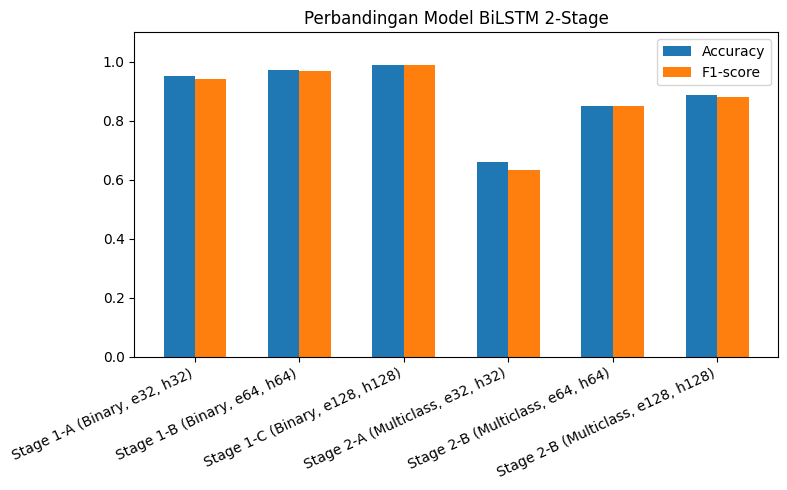

In [134]:
summary_bilstm = pd.DataFrame([
    ["Stage 1-A (Binary, e32, h32)", acc1_a, f1_1a],
    ["Stage 1-B (Binary, e64, h64)", acc1_b, f1_1b],
    ["Stage 1-C (Binary, e128, h128)", acc1_c, f1_1c],
    ["Stage 2-A (Multiclass, e32, h32)", acc2_a, f1_2a],
    ["Stage 2-B (Multiclass, e64, h64)", acc2_b, f1_2b],
    ["Stage 2-B (Multiclass, e128, h128)", acc2_c, f1_2c],
], columns=["Model", "Accuracy", "F1-score"])

display(summary_bilstm)

plt.figure(figsize=(8,5))
x = np.arange(len(summary_bilstm))
plt.bar(x - 0.15, summary_bilstm["Accuracy"], width=0.3, label="Accuracy")
plt.bar(x + 0.15, summary_bilstm["F1-score"], width=0.3, label="F1-score")
plt.xticks(x, summary_bilstm["Model"], rotation=25, ha="right")
plt.ylim(0.0, 1.1)
plt.legend()
plt.title("Perbandingan Model BiLSTM 2-Stage")
plt.tight_layout()
plt.show()


======= Memulai Evaluasi Model =======

--- Mengevaluasi Model 1-A ---
Laporan Klasifikasi Model 1-A:
               precision    recall  f1-score   support

non sepakbola     0.9811    0.8667    0.9204        60
    sepakbola     0.9375    0.9917    0.9639       121

     accuracy                         0.9503       181
    macro avg     0.9593    0.9292    0.9421       181
 weighted avg     0.9520    0.9503    0.9494       181



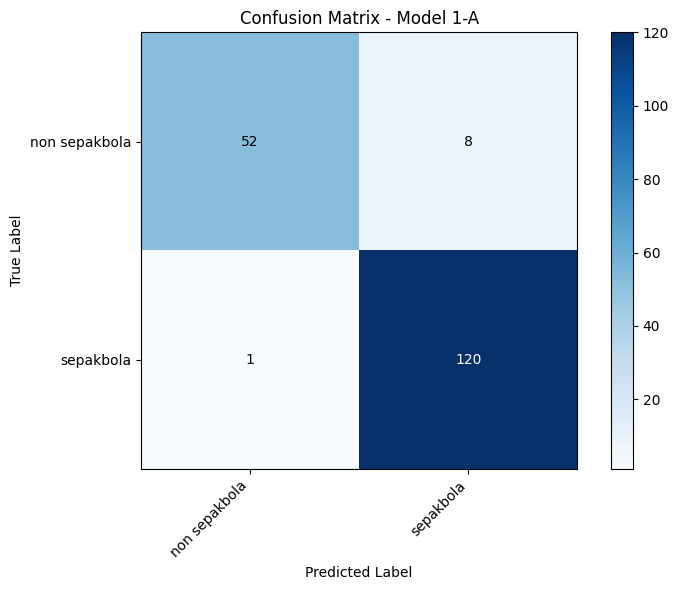


--- Mengevaluasi Model 1-B ---
Laporan Klasifikasi Model 1-B:
               precision    recall  f1-score   support

non sepakbola     0.9825    0.9333    0.9573        60
    sepakbola     0.9677    0.9917    0.9796       121

     accuracy                         0.9724       181
    macro avg     0.9751    0.9625    0.9684       181
 weighted avg     0.9726    0.9724    0.9722       181



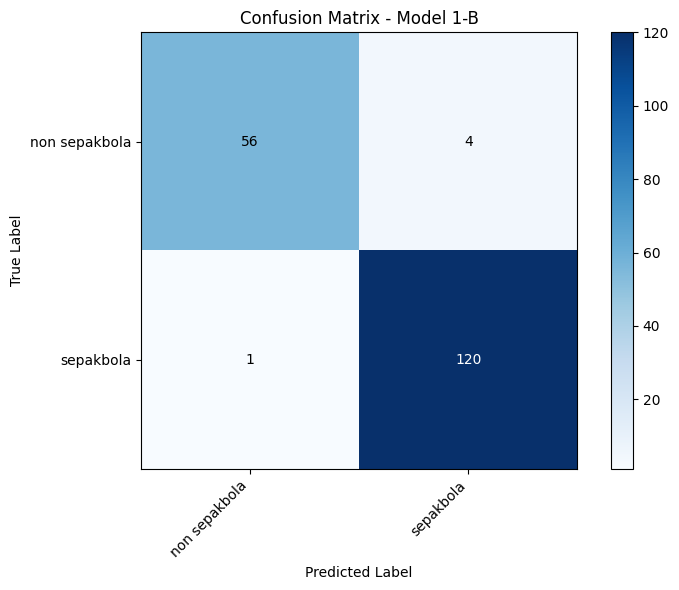


--- Mengevaluasi Model 1-C ---
Laporan Klasifikasi Model 1-C:
               precision    recall  f1-score   support

non sepakbola     0.9833    0.9833    0.9833        60
    sepakbola     0.9917    0.9917    0.9917       121

     accuracy                         0.9890       181
    macro avg     0.9875    0.9875    0.9875       181
 weighted avg     0.9890    0.9890    0.9890       181



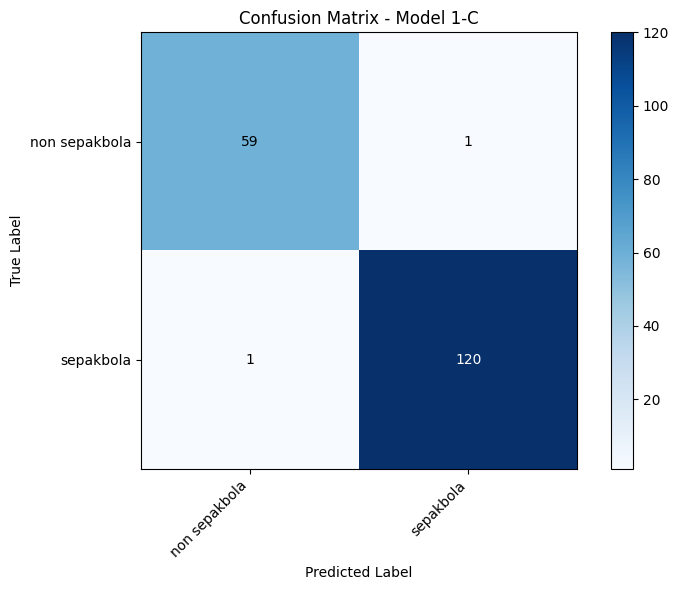


======= Evaluasi Stage 1 Selesai =======

======= Memulai Evaluasi Model Stage 2 =======

--- Mengevaluasi Model 2-A ---
Laporan Klasifikasi Model 2-A:
                precision    recall  f1-score   support

liga-indonesia     0.7447    0.9459    0.8333        37
  liga-inggris     0.6000    0.5357    0.5660        28
   liga-italia     0.5000    0.4483    0.4727        29
  liga-spanyol     0.7059    0.6316    0.6667        38

      accuracy                         0.6591       132
     macro avg     0.6376    0.6404    0.6347       132
  weighted avg     0.6491    0.6591    0.6494       132



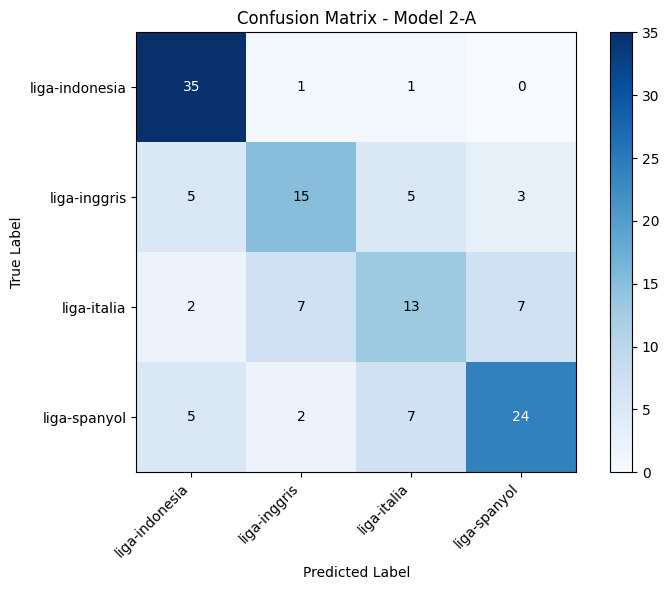


--- Mengevaluasi Model 2-B ---
Laporan Klasifikasi Model 2-B:
                precision    recall  f1-score   support

liga-indonesia     0.8889    0.8649    0.8767        37
  liga-inggris     0.8065    0.8929    0.8475        28
   liga-italia     0.8621    0.8621    0.8621        29
  liga-spanyol     0.8333    0.7895    0.8108        38

      accuracy                         0.8485       132
     macro avg     0.8477    0.8523    0.8493       132
  weighted avg     0.8495    0.8485    0.8483       132



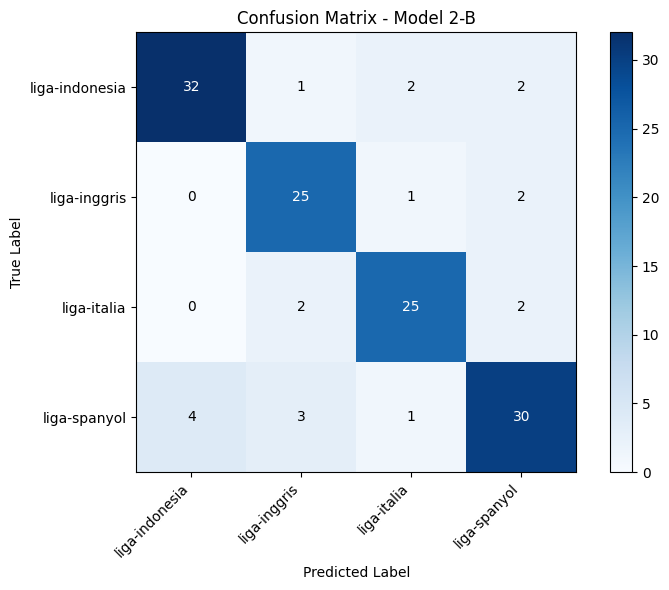


--- Mengevaluasi Model 2-C ---
Laporan Klasifikasi Model 2-C:
                precision    recall  f1-score   support

liga-indonesia     0.9459    0.9459    0.9459        37
  liga-inggris     0.7857    0.7857    0.7857        28
   liga-italia     0.8710    0.9310    0.9000        29
  liga-spanyol     0.9167    0.8684    0.8919        38

      accuracy                         0.8864       132
     macro avg     0.8798    0.8828    0.8809       132
  weighted avg     0.8871    0.8864    0.8863       132



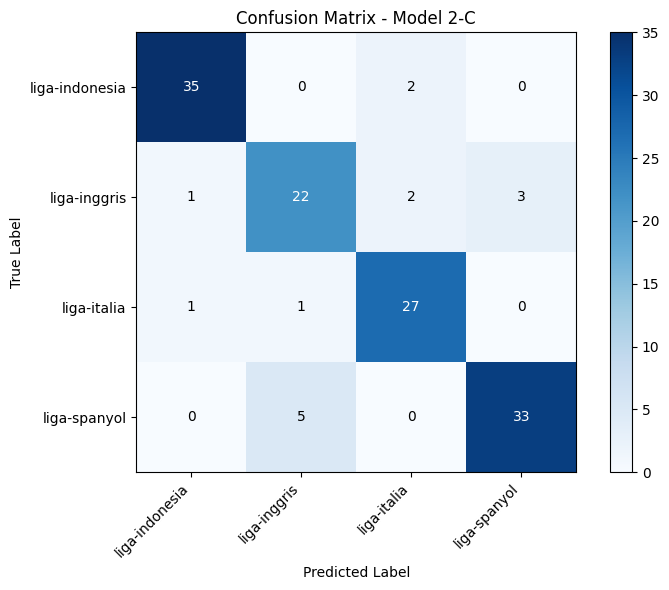


======= Evaluasi Stage 2 Selesai =======


In [135]:
# Hapus salah satu blok "Evaluasi Selesai" yang duplikat.
# Gunakan blok yang sudah diperbaiki ini.

print("======= Memulai Evaluasi Model =======")

# --- Evaluasi Model STAGE 1 (Binary) ---
print("\n--- Mengevaluasi Model 1-A ---")
# Tidak perlu menjalankan evaluate_model lagi, Anda sudah punya hasilnya
# Cukup plot hasil yang sudah ada
print("Laporan Klasifikasi Model 1-A:")
print(report1_a)
# PERBAIKAN: Gunakan label biner yang benar
plot_confusion_matrix(labels1_a, preds1_a, ["non sepakbola", "sepakbola"], title='Confusion Matrix - Model 1-A')

print("\n--- Mengevaluasi Model 1-B ---")
print("Laporan Klasifikasi Model 1-B:")
print(report1_b)
# PERBAIKAN: Gunakan label biner yang benar
plot_confusion_matrix(labels1_b, preds1_b, ["non sepakbola", "sepakbola"], title='Confusion Matrix - Model 1-B')

print("\n--- Mengevaluasi Model 1-C ---")
print("Laporan Klasifikasi Model 1-C:")
print(report1_c)
# PERBAIKAN: Gunakan label biner yang benar
plot_confusion_matrix(labels1_c, preds1_c, ["non sepakbola", "sepakbola"], title='Confusion Matrix - Model 1-C')

print("\n======= Evaluasi Stage 1 Selesai =======")


print("\n======= Memulai Evaluasi Model Stage 2 =======")

# --- Evaluasi Model STAGE 2 (Multiclass) ---
print("\n--- Mengevaluasi Model 2-A ---")
print("Laporan Klasifikasi Model 2-A:")
print(report2_a)
# PERBAIKAN: Gunakan label_encoder2.classes_
plot_confusion_matrix(labels2_a, preds2_a, label_encoder2.classes_, title='Confusion Matrix - Model 2-A')

print("\n--- Mengevaluasi Model 2-B ---")
print("Laporan Klasifikasi Model 2-B:")
print(report2_b)
# PERBAIKAN: Gunakan label_encoder2.classes_
plot_confusion_matrix(labels2_b, preds2_b, label_encoder2.classes_, title='Confusion Matrix - Model 2-B')

print("\n--- Mengevaluasi Model 2-C ---")
print("Laporan Klasifikasi Model 2-C:")
print(report2_c)
# PERBAIKAN: Gunakan label_encoder2.classes_
plot_confusion_matrix(labels2_c, preds2_c, label_encoder2.classes_, title='Confusion Matrix - Model 2-C')

print("\n======= Evaluasi Stage 2 Selesai =======")

In [ ]:
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report, 
    precision_score,  # <-- Tambahkan ini
    recall_score      # <-- Tambahkan ini
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("💻 Device:", device)


💻 Device: cuda


In [7]:
class IndoBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
df_train = pd.read_csv(os.path.join(dataset_path, 'preprocessed-dataset.csv'))

In [8]:
# =====================================================
# 📦 Dataset IndoBERT 2-Stage
# =====================================================

df_stage1 = df_train.copy()
df_stage1['is_sepakbola'] = df_stage1['label'].apply(lambda x: 0 if x == 'non-sepakbola' else 1)

# --- Stage 1: Binary
X1 = df_stage1['clean_text'].astype(str).values
y1 = df_stage1['is_sepakbola'].values

label_encoder1 = LabelEncoder()
y1_encoded = label_encoder1.fit_transform(y1)
num_classes1 = len(label_encoder1.classes_)
print("Label Stage 1:", label_encoder1.classes_)

# --- Stage 2: Multiclass (4 liga)
df_stage2 = df_stage1[df_stage1['is_sepakbola'] == 1]
X2 = df_stage2['clean_text'].astype(str).values
y2 = df_stage2['label'].values

label_encoder2 = LabelEncoder()
y2_encoded = label_encoder2.fit_transform(y2)
num_classes2 = len(label_encoder2.classes_)
print("Label Stage 2:", label_encoder2.classes_)


Label Stage 1: [0 1]
Label Stage 2: ['liga-indonesia' 'liga-inggris' 'liga-italia' 'liga-spanyol']


In [54]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# --- Split Stage 1
X1_train, X1_temp, y1_train, y1_temp = train_test_split(X1, y1, test_size=0.2, random_state=42)
X1_valid, X1_test, y1_valid, y1_test = train_test_split(X1_temp, y1_temp, test_size=0.5, random_state=42)

# --- Split Stage 2
X2_train, X2_temp, y2_train, y2_temp = train_test_split(X2, y2_encoded, test_size=0.2, random_state=42)
X2_valid, X2_test, y2_valid, y2_test = train_test_split(X2_temp, y2_temp, test_size=0.5, random_state=42)

train_dataset1 = IndoBERTDataset(X1_train, y1_train, tokenizer)
valid_dataset1 = IndoBERTDataset(X1_valid, y1_valid, tokenizer)
test_dataset1  = IndoBERTDataset(X1_test,  y1_test,  tokenizer)

train_dataset2 = IndoBERTDataset(X2_train, y2_train, tokenizer)
valid_dataset2 = IndoBERTDataset(X2_valid, y2_valid, tokenizer)
test_dataset2  = IndoBERTDataset(X2_test,  y2_test,  tokenizer)


In [55]:
def get_training_args(model_name, lr, epochs, log_dir):
    return TrainingArguments(
        output_dir=f'./results_{model_name}',
        do_train=True,
        do_eval=True,
        save_steps=500,                  # simpan setiap 500 langkah
        save_total_limit=2,              # maksimal simpan 2 checkpoint
        learning_rate=lr,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_dir=f'./{log_dir}',
        logging_steps=50
    )


import numpy as np
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

def evaluate_indobert(trainer, test_dataset, target_names):
    """
    Mengevaluasi model Trainer Hugging Face dan mengembalikan 
    laporan, acc, f1, serta label dan prediksi mentah untuk plotting.
    """
    # Lakukan prediksi
    pred_output = trainer.predict(test_dataset)
    
    # Ekstrak prediksi dan label
    preds = np.argmax(pred_output.predictions, axis=1) # Ini adalah y_pred
    labels = pred_output.label_ids                  # Ini adalah y_true
    
    # Hitung metrik
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    
    # Buat laporan
    report = classification_report(labels, preds, target_names=target_names, digits=4, zero_division=0)
    
    # Kembalikan labels & preds untuk plotting
    return report, acc, f1, labels, preds

# Clear memory
def clear_memory(model, trainer):
    model.to('cpu')
    del model
    torch.cuda.empty_cache()

    trainer.model.to('cpu')
    del trainer.model
    del trainer
    torch.cuda.empty_cache()

    gc.collect()
    torch.cuda.empty_cache()

In [58]:
# =====================================================
# ⚽️ Stage 1: Binary (Sepakbola vs Non-sepakbola)
# =====================================================

# print("🚀 Stage 1 IndoBERT — Binary Classification")

# --- Model A (baseline)
model1_a = BertForSequenceClassification.from_pretrained("./results_indobert_stage1_A/checkpoint-543", num_labels=2)
training_args1_a = get_training_args("indobert_stage1_A", lr=1e-5, epochs=3, log_dir="logs_stage1_A")

trainer1_a = Trainer(
    model=model1_a,
    args=training_args1_a,
    train_dataset=train_dataset1,
    eval_dataset=valid_dataset1,
    tokenizer=tokenizer
)
# trainer1_a.train()

# pred1_a = trainer1_a.predict(test_dataset1)
# y_pred1_a = np.argmax(pred1_a.predictions, axis=1)

# print("\n=== Evaluasi IndoBERT Stage 1-A ===")
# cm = confusion_matrix(y1_test, y_pred1_a)
# labels = ["non-sepakbola", "sepakbola"]

# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix — IndoBERT Stage 1-A (Binary)')
# plt.show()

print("======= Memulai Evaluasi IndoBERT Stage 1-A =======")

# --- Evaluasi Model 1-A (Train) ---
print("\n--- Mengevaluasi IndoBERT 1-A (Train Set) ---")
report1_at, acc1_at, f1_1at, label1_at, pred1_at = evaluate_indobert(trainer1_a, train_dataset1, ["non-sepakbola", "sepakbola"])
print(report1_at)

# --- Evaluasi Model 1-A (Valid) ---
print("\n--- Mengevaluasi IndoBERT 1-A (Validation Set) ---")
report1_av, acc1_av, f1_1av, label1_av, pred1_av = evaluate_indobert(trainer1_a, valid_dataset1, ["non-sepakbola", "sepakbola"])
print(report1_av)

# --- Evaluasi Model 1-A (Test) ---
print("\n--- Mengevaluasi IndoBERT 1-A (Test Set) ---")
report1_ats, acc1_ats, f1_1ats, label1_ats, pred1_ats = evaluate_indobert(trainer1_a, test_dataset1, ["non-sepakbola", "sepakbola"])
print(report1_ats)

print("\n======= Evaluasi IndoBERT Stage 1-A Selesai =======")

model1_a.to('cpu')
del model1_a
torch.cuda.empty_cache()

trainer1_a.model.to('cpu')
del trainer1_a.model
del trainer1_a
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

C:\Users\vinco\AppData\Local\Temp\ipykernel_37836\2806757340.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1_a = Trainer(


======= Memulai Evaluasi IndoBERT Stage 1-A =======

--- Mengevaluasi IndoBERT 1-A (Train Set) ---


               precision    recall  f1-score   support

non-sepakbola     1.0000    1.0000    1.0000       369
    sepakbola     1.0000    1.0000    1.0000      1076

     accuracy                         1.0000      1445
    macro avg     1.0000    1.0000    1.0000      1445
 weighted avg     1.0000    1.0000    1.0000      1445


--- Mengevaluasi IndoBERT 1-A (Validation Set) ---


               precision    recall  f1-score   support

non-sepakbola     1.0000    1.0000    1.0000        67
    sepakbola     1.0000    1.0000    1.0000       114

     accuracy                         1.0000       181
    macro avg     1.0000    1.0000    1.0000       181
 weighted avg     1.0000    1.0000    1.0000       181


--- Mengevaluasi IndoBERT 1-A (Test Set) ---


               precision    recall  f1-score   support

non-sepakbola     1.0000    1.0000    1.0000        60
    sepakbola     1.0000    1.0000    1.0000       121

     accuracy                         1.0000       181
    macro avg     1.0000    1.0000    1.0000       181
 weighted avg     1.0000    1.0000    1.0000       181


======= Evaluasi IndoBERT Stage 1-A Selesai =======


In [61]:
# --- Model B (tuning)
# model1_b = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)
model1_b = BertForSequenceClassification.from_pretrained("./results_indobert_stage1_B/checkpoint-724", num_labels=2)
training_args1_b = get_training_args("indobert_stage1_B", lr=3e-5, epochs=4, log_dir="logs_stage1_B")

trainer1_b = Trainer(
    model=model1_b,
    args=training_args1_b,
    train_dataset=train_dataset1,
    eval_dataset=valid_dataset1,
    tokenizer=tokenizer
)
# trainer1_b.train()

# pred1_b = trainer1_b.predict(test_dataset1)
# y_pred1_b = np.argmax(pred1_b.predictions, axis=1)

# print("\n=== Evaluasi IndoBERT Stage 1-B ===")
# cm = confusion_matrix(y1_test, y_pred1_b)
# labels = ["non-sepakbola", "sepakbola"]

# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix — IndoBERT Stage 1-B (Binary)')
# plt.show()


print("======= Memulai Evaluasi IndoBERT Stage 1-B =======")

# --- Evaluasi Model 1-B (Train) ---
print("\n--- Mengevaluasi IndoBERT 1-B (Train Set) ---")
report1_bt, acc1_bt, f1_1bt, label1_bt, pred1_bt = evaluate_indobert(trainer1_b, train_dataset1, ["non-sepakbola", "sepakbola"])
print(report1_bt)

# --- Evaluasi Model 1-B (Valid) ---
print("\n--- Mengevaluasi IndoBERT 1-B (Validation Set) ---")
report1_bv, acc1_bv, f1_1bv, label1_bv, pred1_bv = evaluate_indobert(trainer1_b, valid_dataset1, ["non-sepakbola", "sepakbola"])
print(report1_bv)

# --- Evaluasi Model 1-B (Test) ---
print("\n--- Mengevaluasi IndoBERT 1-B (Test Set) ---")
report1_bts, acc1_bts, f1_1bts, label1_bts, pred1_bts = evaluate_indobert(trainer1_b, test_dataset1, ["non-sepakbola", "sepakbola"])
print(report1_bts)

print("\n======= Evaluasi IndoBERT Stage 1-B Selesai =======")

model1_b.to('cpu')
del model1_b
torch.cuda.empty_cache()

trainer1_b.model.to('cpu')
del trainer1_b.model
del trainer1_b
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

C:\Users\vinco\AppData\Local\Temp\ipykernel_37836\2719667813.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1_b = Trainer(


======= Memulai Evaluasi IndoBERT Stage 1-B =======

--- Mengevaluasi IndoBERT 1-B (Train Set) ---


               precision    recall  f1-score   support

non-sepakbola     1.0000    1.0000    1.0000       369
    sepakbola     1.0000    1.0000    1.0000      1076

     accuracy                         1.0000      1445
    macro avg     1.0000    1.0000    1.0000      1445
 weighted avg     1.0000    1.0000    1.0000      1445


--- Mengevaluasi IndoBERT 1-B (Validation Set) ---


               precision    recall  f1-score   support

non-sepakbola     1.0000    1.0000    1.0000        67
    sepakbola     1.0000    1.0000    1.0000       114

     accuracy                         1.0000       181
    macro avg     1.0000    1.0000    1.0000       181
 weighted avg     1.0000    1.0000    1.0000       181


--- Mengevaluasi IndoBERT 1-B (Test Set) ---


               precision    recall  f1-score   support

non-sepakbola     1.0000    1.0000    1.0000        60
    sepakbola     1.0000    1.0000    1.0000       121

     accuracy                         1.0000       181
    macro avg     1.0000    1.0000    1.0000       181
 weighted avg     1.0000    1.0000    1.0000       181


======= Evaluasi IndoBERT Stage 1-B Selesai =======


In [62]:
# --- Model B (tuning)
# model1_c = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)
model1_c = BertForSequenceClassification.from_pretrained("./results_indobert_stage1_C/checkpoint-905", num_labels=2)
training_args1_c = get_training_args("indobert_stage1_C", lr=5e-5, epochs=5, log_dir="logs_stage1_C")

trainer1_c = Trainer(
    model=model1_c,
    args=training_args1_c,
    train_dataset=train_dataset1,
    eval_dataset=valid_dataset1,
    tokenizer=tokenizer
)
# trainer1_c.train()

# pred1_c = trainer1_c.predict(test_dataset1)
# y_pred1_c = np.argmax(pred1_c.predictions, axis=1)

# print("\n=== Evaluasi IndoBERT Stage 1-A ===")
# cm = confusion_matrix(y1_test, y_pred1_c)
# labels = ["non-sepakbola", "sepakbola"]

# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix — IndoBERT Stage 1-A (Binary)')
# plt.show()

# report1_c, acc1_c, f1_1c = evaluate_indobert(trainer1_c, test_dataset1, ["non-sepakbola", "sepakbola"])
# print(report1_c)

print("======= Memulai Evaluasi IndoBERT Stage 1-C =======")

# --- Evaluasi Model 1-C (Train) ---
print("\n--- Mengevaluasi IndoBERT 1-C (Train Set) ---")
report1_ct, acc1_ct, f1_1ct, label1_ct, pred1_ct = evaluate_indobert(trainer1_c, train_dataset1, ["non-sepakbola", "sepakbola"])
print(report1_ct)

# --- Evaluasi Model 1-C (Valid) ---
print("\n--- Mengevaluasi IndoBERT 1-C (Validation Set) ---")
report1_cv, acc1_cv, f1_1cv, label1_cv, pred1_cv = evaluate_indobert(trainer1_c, valid_dataset1, ["non-sepakbola", "sepakbola"])
print(report1_cv)

# --- Evaluasi Model 1-C (Test) ---
print("\n--- Mengevaluasi IndoBERT 1-C (Test Set) ---")
report1_cts, acc1_cts, f1_1cts, label1_cts, pred1_cts = evaluate_indobert(trainer1_c, test_dataset1, ["non-sepakbola", "sepakbola"])
print(report1_cts)

print("\n======= Evaluasi IndoBERT Stage 1-C Selesai =======")

model1_c.to('cpu')
del model1_c
torch.cuda.empty_cache()

trainer1_c.model.to('cpu')
del trainer1_c.model
del trainer1_c
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

C:\Users\vinco\AppData\Local\Temp\ipykernel_37836\2902242793.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1_c = Trainer(


======= Memulai Evaluasi IndoBERT Stage 1-C =======

--- Mengevaluasi IndoBERT 1-C (Train Set) ---


               precision    recall  f1-score   support

non-sepakbola     1.0000    1.0000    1.0000       369
    sepakbola     1.0000    1.0000    1.0000      1076

     accuracy                         1.0000      1445
    macro avg     1.0000    1.0000    1.0000      1445
 weighted avg     1.0000    1.0000    1.0000      1445


--- Mengevaluasi IndoBERT 1-C (Validation Set) ---


               precision    recall  f1-score   support

non-sepakbola     1.0000    1.0000    1.0000        67
    sepakbola     1.0000    1.0000    1.0000       114

     accuracy                         1.0000       181
    macro avg     1.0000    1.0000    1.0000       181
 weighted avg     1.0000    1.0000    1.0000       181


--- Mengevaluasi IndoBERT 1-C (Test Set) ---


               precision    recall  f1-score   support

non-sepakbola     1.0000    1.0000    1.0000        60
    sepakbola     1.0000    1.0000    1.0000       121

     accuracy                         1.0000       181
    macro avg     1.0000    1.0000    1.0000       181
 weighted avg     1.0000    1.0000    1.0000       181


======= Evaluasi IndoBERT Stage 1-C Selesai =======


In [63]:
# =====================================================
# 📦 Dataset IndoBERT 2-Stage
# =====================================================

df_stage1 = df_train.copy()
df_stage1['is_sepakbola'] = df_stage1['label'].apply(lambda x: 0 if x == 'non-sepakbola' else 1)

# --- Stage 1: Binary
X1 = df_stage1['clean_text'].astype(str).values
y1 = df_stage1['is_sepakbola'].values

# --- Stage 2: Multiclass (4 liga)
df_stage2 = df_stage1[df_stage1['is_sepakbola'] == 1]
X2 = df_stage2['clean_text'].astype(str).values
y2 = df_stage2['label'].values

label_encoder2 = LabelEncoder()
y2_encoded = label_encoder2.fit_transform(y2)
num_classes2 = len(label_encoder2.classes_)
print("Label Stage 2:", label_encoder2.classes_)


Label Stage 2: ['liga-indonesia' 'liga-inggris' 'liga-italia' 'liga-spanyol']


In [65]:
# model2_a = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=num_classes2)
model2_a = BertForSequenceClassification.from_pretrained("./results_indobert_stage2_A/checkpoint-393", num_labels=num_classes2)
training_args2_a = get_training_args("indobert_stage2_A", lr=1e-5, epochs=3, log_dir="logs_stage2_A")

trainer2_a = Trainer(
    model=model2_a,
    args=training_args2_a,
    train_dataset=train_dataset2,
    eval_dataset=valid_dataset2,
    tokenizer=tokenizer
)
# trainer2_a.train()

# pred2_a = trainer2_a.predict(test_dataset2)
# y_pred2_a = np.argmax(pred2_a.predictions, axis=1)

# print("\n=== Evaluasi IndoBERT Stage 2-A ===")
# cm = confusion_matrix(y2_test, y_pred2_a)
# labels = ["non-sepakbola", "sepakbola"]

# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix — IndoBERT Stage 2-A (Binary)')
# plt.show()

print("======= Memulai Evaluasi IndoBERT Stage 2-A =======")

# --- Evaluasi Model 2-A (Train) ---
print("\n--- Mengevaluasi IndoBERT 2-A (Train Set) ---")
report2_at, acc2_at, f2_1at, label2_at, pred2_at = evaluate_indobert(trainer2_a, train_dataset2, label_encoder2.classes_)
print(report2_at)

# --- Evaluasi Model 2-A (Valid) ---
print("\n--- Mengevaluasi IndoBERT 2-A (Validation Set) ---")
report2_av, acc2_av, f2_1av, label2_av, pred2_av = evaluate_indobert(trainer2_a, valid_dataset2, label_encoder2.classes_)
print(report2_av)

# --- Evaluasi Model 2-A (Test) ---
print("\n--- Mengevaluasi IndoBERT 2-A (Test Set) ---")
report2_ats, acc2_ats, f2_1ats, label2_ats, pred2_ats = evaluate_indobert(trainer2_a, test_dataset2, label_encoder2.classes_)
print(report2_ats)

print("\n======= Evaluasi IndoBERT Stage 2-A Selesai =======")


model2_a.to('cpu')
del model2_a
torch.cuda.empty_cache()

trainer2_a.model.to('cpu')
del trainer2_a.model
del trainer2_a
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

C:\Users\vinco\AppData\Local\Temp\ipykernel_37836\2771631568.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer2_a = Trainer(


======= Memulai Evaluasi IndoBERT Stage 2-A =======

--- Mengevaluasi IndoBERT 2-A (Train Set) ---


                precision    recall  f1-score   support

liga-indonesia     1.0000    0.9962    0.9981       262
  liga-inggris     0.9963    0.9963    0.9963       272
   liga-italia     0.9961    0.9961    0.9961       256
  liga-spanyol     0.9961    1.0000    0.9981       258

      accuracy                         0.9971      1048
     macro avg     0.9971    0.9972    0.9971      1048
  weighted avg     0.9971    0.9971    0.9971      1048


--- Mengevaluasi IndoBERT 2-A (Validation Set) ---


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        28
  liga-inggris     0.9655    1.0000    0.9825        28
   liga-italia     1.0000    0.9767    0.9882        43
  liga-spanyol     1.0000    1.0000    1.0000        32

      accuracy                         0.9924       131
     macro avg     0.9914    0.9942    0.9927       131
  weighted avg     0.9926    0.9924    0.9924       131


--- Mengevaluasi IndoBERT 2-A (Test Set) ---


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        37
  liga-inggris     0.9333    1.0000    0.9655        28
   liga-italia     1.0000    0.9310    0.9643        29
  liga-spanyol     1.0000    1.0000    1.0000        38

      accuracy                         0.9848       132
     macro avg     0.9833    0.9828    0.9825       132
  weighted avg     0.9859    0.9848    0.9848       132


======= Evaluasi IndoBERT Stage 2-A Selesai =======


In [69]:
# model2_b = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=num_classes2)
model2_b = BertForSequenceClassification.from_pretrained("./results_indobert_stage2_B/checkpoint-524", num_labels=num_classes2)
training_args2_b = get_training_args("indobert_stage2_B", lr=3e-5, epochs=4, log_dir="logs_stage2_B")

trainer2_b = Trainer(
    model=model2_b,
    args=training_args2_b,
    train_dataset=train_dataset2,
    eval_dataset=valid_dataset2,
    tokenizer=tokenizer
)
# trainer2_b.train()

# pred2_b = trainer2_b.predict(test_dataset2)
# y_pred2_b = np.argmax(pred2_b.predictions, axis=1)

# print("\n=== Evaluasi IndoBERT Stage 1-B ===")
# cm = confusion_matrix(y2_test, y_pred2_b)
# labels = ["non-sepakbola", "sepakbola"]

# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix — IndoBERT Stage 1-B (Binary)')
# plt.show()

print("======= Memulai Evaluasi IndoBERT Stage 2-B =======")

# --- Evaluasi Model 2-B (Train) ---
print("\n--- Mengevaluasi IndoBERT 2-B (Train Set) ---")
report2_bt, acc2_bt, f2_1bt, label2_bt, pred2_bt = evaluate_indobert(trainer2_b, train_dataset2, label_encoder2.classes_)
print(report2_bt)

# --- Evaluasi Model 2-B (Valid) ---
print("\n--- Mengevaluasi IndoBERT 2-B (Validation Set) ---")
report2_bv, acc2_bv, f2_1bv, label2_bv, pred2_bv = evaluate_indobert(trainer2_b, valid_dataset2, label_encoder2.classes_)
print(report2_bv)

# --- Evaluasi Model 2-B (Test) ---
print("\n--- Mengevaluasi IndoBERT 2-B (Test Set) ---")
report2_bts, acc2_bts, f2_1bts, label2_bts, pred2_bts = evaluate_indobert(trainer2_b, test_dataset2, label_encoder2.classes_)
print(report2_bts)

print("\n======= Evaluasi IndoBERT Stage 2-B Selesai =======")

model2_b.to('cpu')
del model2_b
torch.cuda.empty_cache()

trainer2_b.model.to('cpu')
del trainer2_b.model
del trainer2_b
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()


C:\Users\vinco\AppData\Local\Temp\ipykernel_37836\1128386381.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer2_b = Trainer(


======= Memulai Evaluasi IndoBERT Stage 2-B =======

--- Mengevaluasi IndoBERT 2-B (Train Set) ---


                precision    recall  f1-score   support

liga-indonesia     1.0000    0.9962    0.9981       262
  liga-inggris     1.0000    0.9963    0.9982       272
   liga-italia     0.9961    1.0000    0.9981       256
  liga-spanyol     0.9961    1.0000    0.9981       258

      accuracy                         0.9981      1048
     macro avg     0.9981    0.9981    0.9981      1048
  weighted avg     0.9981    0.9981    0.9981      1048


--- Mengevaluasi IndoBERT 2-B (Validation Set) ---


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        28
  liga-inggris     0.9655    1.0000    0.9825        28
   liga-italia     1.0000    0.9767    0.9882        43
  liga-spanyol     1.0000    1.0000    1.0000        32

      accuracy                         0.9924       131
     macro avg     0.9914    0.9942    0.9927       131
  weighted avg     0.9926    0.9924    0.9924       131


--- Mengevaluasi IndoBERT 2-B (Test Set) ---


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        37
  liga-inggris     0.9310    0.9643    0.9474        28
   liga-italia     1.0000    0.9310    0.9643        29
  liga-spanyol     0.9744    1.0000    0.9870        38

      accuracy                         0.9773       132
     macro avg     0.9763    0.9738    0.9747       132
  weighted avg     0.9780    0.9773    0.9773       132


======= Evaluasi IndoBERT Stage 2-B Selesai =======


In [70]:
# model2_c = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=num_classes2)
model2_c = BertForSequenceClassification.from_pretrained("./results_indobert_stage2_C/checkpoint-655", num_labels=num_classes2)
training_args2_c = get_training_args("indobert_stage2_C", lr=5e-5, epochs=5, log_dir="logs_stage2_C")

trainer2_c = Trainer(
    model=model2_c,
    args=training_args2_c,
    train_dataset=train_dataset2,
    eval_dataset=valid_dataset2,
    tokenizer=tokenizer
)
# trainer2_c.train()

# pred2_c = trainer2_c.predict(test_dataset2)
# y_pred2_c = np.argmax(pred2_c.predictions, axis=1)

# print("\n=== Evaluasi IndoBERT Stage 1-A ===")
# cm = confusion_matrix(y2_test, y_pred2_c)
# labels = ["non-sepakbola", "sepakbola"]

# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix — IndoBERT Stage 1-A (Binary)')
# plt.show()

# report2_c, acc2_c, f1_2a = evaluate_indobert(trainer2_c, test_dataset2, label_encoder2.classes_)
# print(report2_c)

print("======= Memulai Evaluasi IndoBERT Stage 2-C =======")

# --- Evaluasi Model 2-C (Train) ---
print("\n--- Mengevaluasi IndoBERT 2-C (Train Set) ---")
report2_ct, acc2_ct, f2_1ct, label2_ct, pred2_ct = evaluate_indobert(trainer2_c, train_dataset2, label_encoder2.classes_)
print(report2_ct)

# --- Evaluasi Model 2-C (Valid) ---
print("\n--- Mengevaluasi IndoBERT 2-C (Validation Set) ---")
report2_cv, acc2_cv, f2_1cv, label2_cv, pred2_cv = evaluate_indobert(trainer2_c, valid_dataset2, label_encoder2.classes_)
print(report2_cv)

# --- Evaluasi Model 2-C (Test) ---
print("\n--- Mengevaluasi IndoBERT 2-C (Test Set) ---")
report2_cts, acc2_cts, f2_1cts, label2_cts, pred2_cts = evaluate_indobert(trainer2_c, test_dataset2, label_encoder2.classes_)
print(report2_cts)

print("\n======= Evaluasi IndoBERT Stage 2-C Selesai =======")

model2_c.to('cpu')
del model2_c
torch.cuda.empty_cache()

trainer2_c.model.to('cpu')
del trainer2_c.model
del trainer2_c
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

C:\Users\vinco\AppData\Local\Temp\ipykernel_37836\3229621288.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer2_c = Trainer(


======= Memulai Evaluasi IndoBERT Stage 2-C =======

--- Mengevaluasi IndoBERT 2-C (Train Set) ---


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000       262
  liga-inggris     1.0000    0.9963    0.9982       272
   liga-italia     0.9961    1.0000    0.9981       256
  liga-spanyol     1.0000    1.0000    1.0000       258

      accuracy                         0.9990      1048
     macro avg     0.9990    0.9991    0.9991      1048
  weighted avg     0.9990    0.9990    0.9990      1048


--- Mengevaluasi IndoBERT 2-C (Validation Set) ---


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        28
  liga-inggris     0.9643    0.9643    0.9643        28
   liga-italia     0.9767    0.9767    0.9767        43
  liga-spanyol     1.0000    1.0000    1.0000        32

      accuracy                         0.9847       131
     macro avg     0.9853    0.9853    0.9853       131
  weighted avg     0.9847    0.9847    0.9847       131


--- Mengevaluasi IndoBERT 2-C (Test Set) ---


                precision    recall  f1-score   support

liga-indonesia     1.0000    1.0000    1.0000        37
  liga-inggris     0.9333    1.0000    0.9655        28
   liga-italia     1.0000    0.9310    0.9643        29
  liga-spanyol     1.0000    1.0000    1.0000        38

      accuracy                         0.9848       132
     macro avg     0.9833    0.9828    0.9825       132
  weighted avg     0.9859    0.9848    0.9848       132


======= Evaluasi IndoBERT Stage 2-C Selesai =======


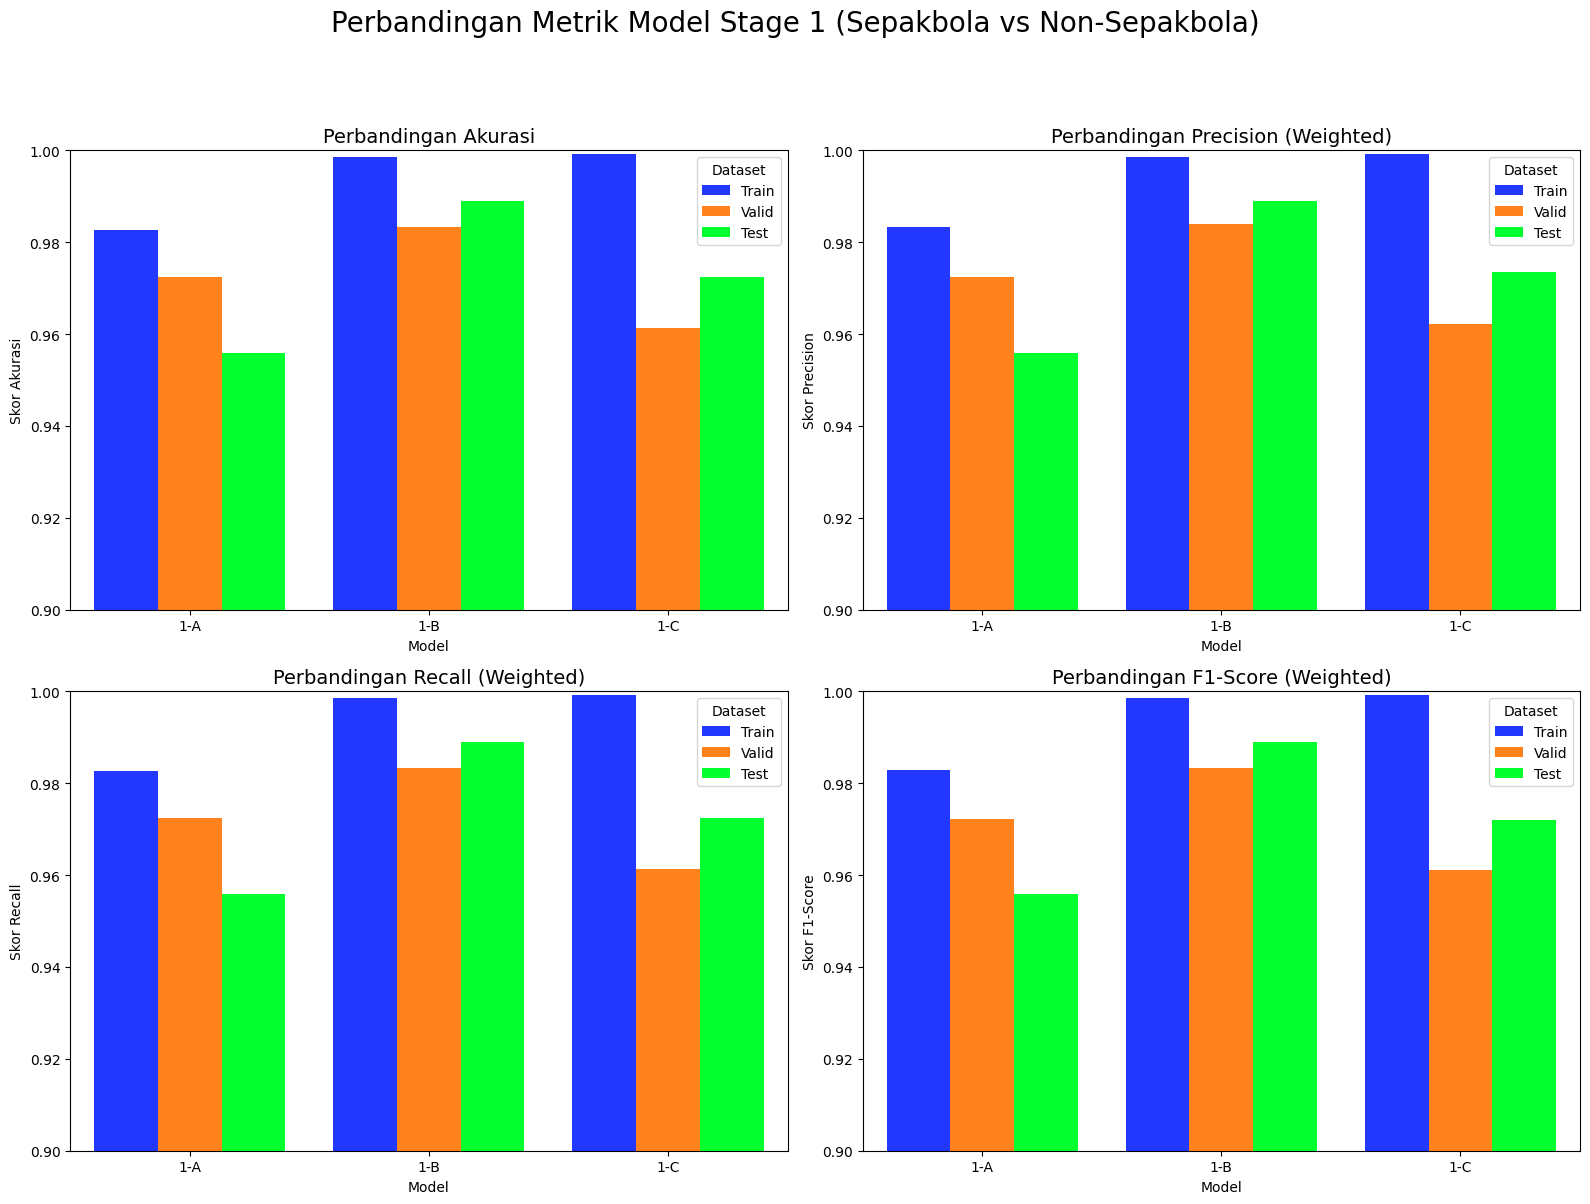

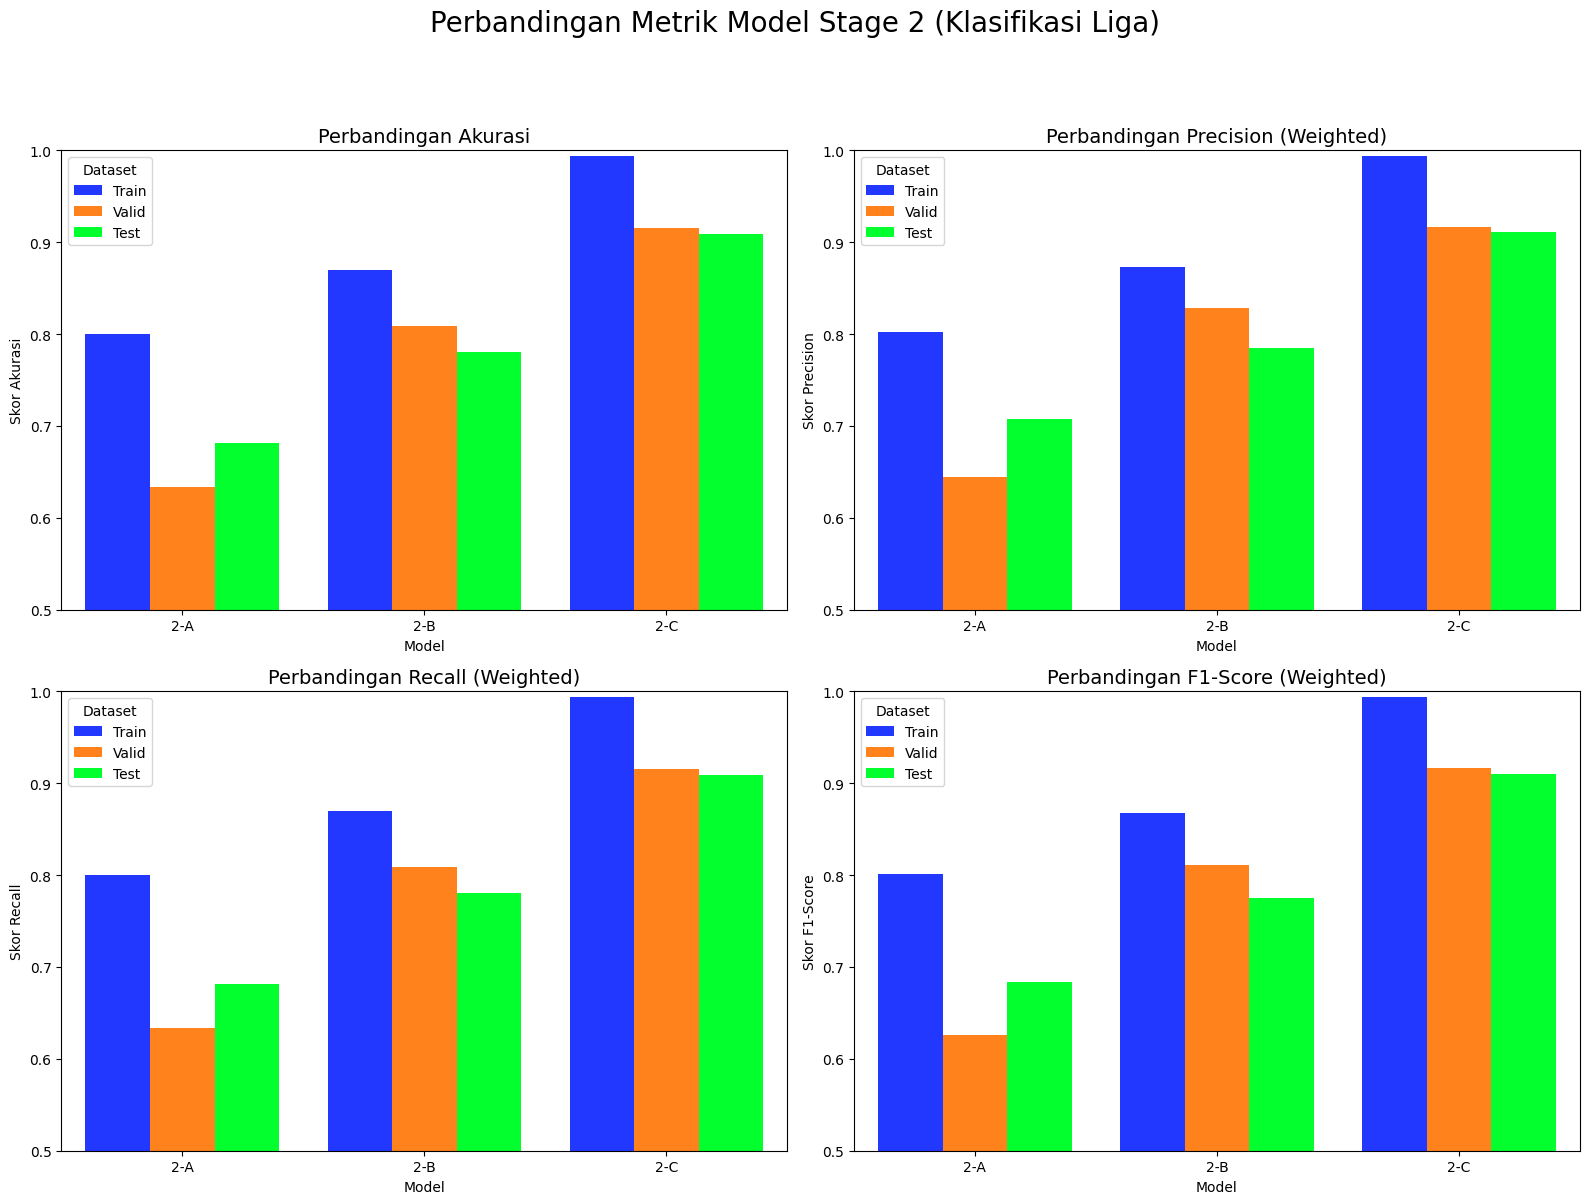

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Menyusun data dari laporan Anda BILSTM
data = {
    'Model': [
        '1-A', '1-A', '1-A', '1-B', '1-B', '1-B', '1-C', '1-C', '1-C',
        '2-A', '2-A', '2-A', '2-B', '2-B', '2-B', '2-C', '2-C', '2-C'
    ],
    'Dataset': [
        'Train', 'Valid', 'Test', 'Train', 'Valid', 'Test', 'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test', 'Train', 'Valid', 'Test', 'Train', 'Valid', 'Test'
    ],
    'Stage': [
        1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2
    ],
    'Accuracy': [
        0.9827, 0.9724, 0.9558, 0.9986, 0.9834, 0.9890, 0.9993, 0.9613, 0.9724,
        0.8006, 0.6336, 0.6818, 0.8702, 0.8092, 0.7803, 0.9943, 0.9160, 0.9091
    ],
    'Precision (Weighted)': [
        0.9833, 0.9724, 0.9558, 0.9986, 0.9839, 0.9890, 0.9993, 0.9623, 0.9735,
        0.8024, 0.6447, 0.7074, 0.8728, 0.8281, 0.7852, 0.9943, 0.9170, 0.9109
    ],
    'Recall (Weighted)': [
        0.9827, 0.9724, 0.9558, 0.9986, 0.9834, 0.9890, 0.9993, 0.9613, 0.9724,
        0.8006, 0.6336, 0.6818, 0.8702, 0.8092, 0.7803, 0.9943, 0.9160, 0.9091
    ],
    'F1-Score (Weighted)': [
        0.9828, 0.9723, 0.9558, 0.9986, 0.9833, 0.9890, 0.9993, 0.9610, 0.9721,
        0.8008, 0.6260, 0.6834, 0.8675, 0.8106, 0.7752, 0.9943, 0.9162, 0.9097
    ]
}

df = pd.DataFrame(data)

# Mengubah format data menjadi "long format" agar mudah di-plot dengan seaborn
df_long = df.melt(id_vars=['Model', 'Dataset', 'Stage'], 
                  value_vars=['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
                  var_name='Metric', value_name='Score')

# Memisahkan data untuk Stage 1 dan Stage 2
df_stage1 = df_long[df_long['Stage'] == 1]
df_stage2 = df_long[df_long['Stage'] == 2]

# --- 2. Visualisasi Model Stage 1 (Sepakbola vs Non-Sepakbola) ---

# Mengatur palet warna
palette = {"Train": "#2238ff", "Valid": "#ff821c", "Test": "#04ff2e"}

# Membuat 4 subplot (2 baris, 2 kolom)
fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('Perbandingan Metrik Model Stage 1 (Sepakbola vs Non-Sepakbola)', fontsize=20, y=1.03)

# Plot 1: Accuracy
sns.barplot(ax=axes1[0, 0], data=df_stage1[df_stage1['Metric'] == 'Accuracy'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes1[0, 0].set_title('Perbandingan Akurasi', fontsize=14)
axes1[0, 0].set_ylabel('Skor Akurasi')
axes1[0, 0].set_ylim(0.9, 1.0) # Set limit Y agar perbedaan kecil terlihat
axes1[0, 0].legend(title='Dataset')

# Plot 2: Precision
sns.barplot(ax=axes1[0, 1], data=df_stage1[df_stage1['Metric'] == 'Precision (Weighted)'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes1[0, 1].set_title('Perbandingan Precision (Weighted)', fontsize=14)
axes1[0, 1].set_ylabel('Skor Precision')
axes1[0, 1].set_ylim(0.9, 1.0)
axes1[0, 1].legend(title='Dataset')

# Plot 3: Recall
sns.barplot(ax=axes1[1, 0], data=df_stage1[df_stage1['Metric'] == 'Recall (Weighted)'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes1[1, 0].set_title('Perbandingan Recall (Weighted)', fontsize=14)
axes1[1, 0].set_ylabel('Skor Recall')
axes1[1, 0].set_ylim(0.9, 1.0)
axes1[1, 0].legend(title='Dataset')

# Plot 4: F1-Score
sns.barplot(ax=axes1[1, 1], data=df_stage1[df_stage1['Metric'] == 'F1-Score (Weighted)'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes1[1, 1].set_title('Perbandingan F1-Score (Weighted)', fontsize=14)
axes1[1, 1].set_ylabel('Skor F1-Score')
axes1[1, 1].set_ylim(0.9, 1.0)
axes1[1, 1].legend(title='Dataset')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


# --- 3. Visualisasi Model Stage 2 (Klasifikasi Liga) ---

# Membuat 4 subplot (2 baris, 2 kolom)
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle('Perbandingan Metrik Model Stage 2 (Klasifikasi Liga)', fontsize=20, y=1.03)

# Plot 1: Accuracy
sns.barplot(ax=axes2[0, 0], data=df_stage2[df_stage2['Metric'] == 'Accuracy'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes2[0, 0].set_title('Perbandingan Akurasi', fontsize=14)
axes2[0, 0].set_ylabel('Skor Akurasi')
axes2[0, 0].set_ylim(0.5, 1.0) # Set limit Y dari 0.5 karena skornya lebih rendah
axes2[0, 0].legend(title='Dataset')

# Plot 2: Precision
sns.barplot(ax=axes2[0, 1], data=df_stage2[df_stage2['Metric'] == 'Precision (Weighted)'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes2[0, 1].set_title('Perbandingan Precision (Weighted)', fontsize=14)
axes2[0, 1].set_ylabel('Skor Precision')
axes2[0, 1].set_ylim(0.5, 1.0)
axes2[0, 1].legend(title='Dataset')

# Plot 3: Recall
sns.barplot(ax=axes2[1, 0], data=df_stage2[df_stage2['Metric'] == 'Recall (Weighted)'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes2[1, 0].set_title('Perbandingan Recall (Weighted)', fontsize=14)
axes2[1, 0].set_ylabel('Skor Recall')
axes2[1, 0].set_ylim(0.5, 1.0)
axes2[1, 0].legend(title='Dataset')

# Plot 4: F1-Score
sns.barplot(ax=axes2[1, 1], data=df_stage2[df_stage2['Metric'] == 'F1-Score (Weighted)'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes2[1, 1].set_title('Perbandingan F1-Score (Weighted)', fontsize=14)
axes2[1, 1].set_ylabel('Skor F1-Score')
axes2[1, 1].set_ylim(0.5, 1.0)
axes2[1, 1].legend(title='Dataset')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

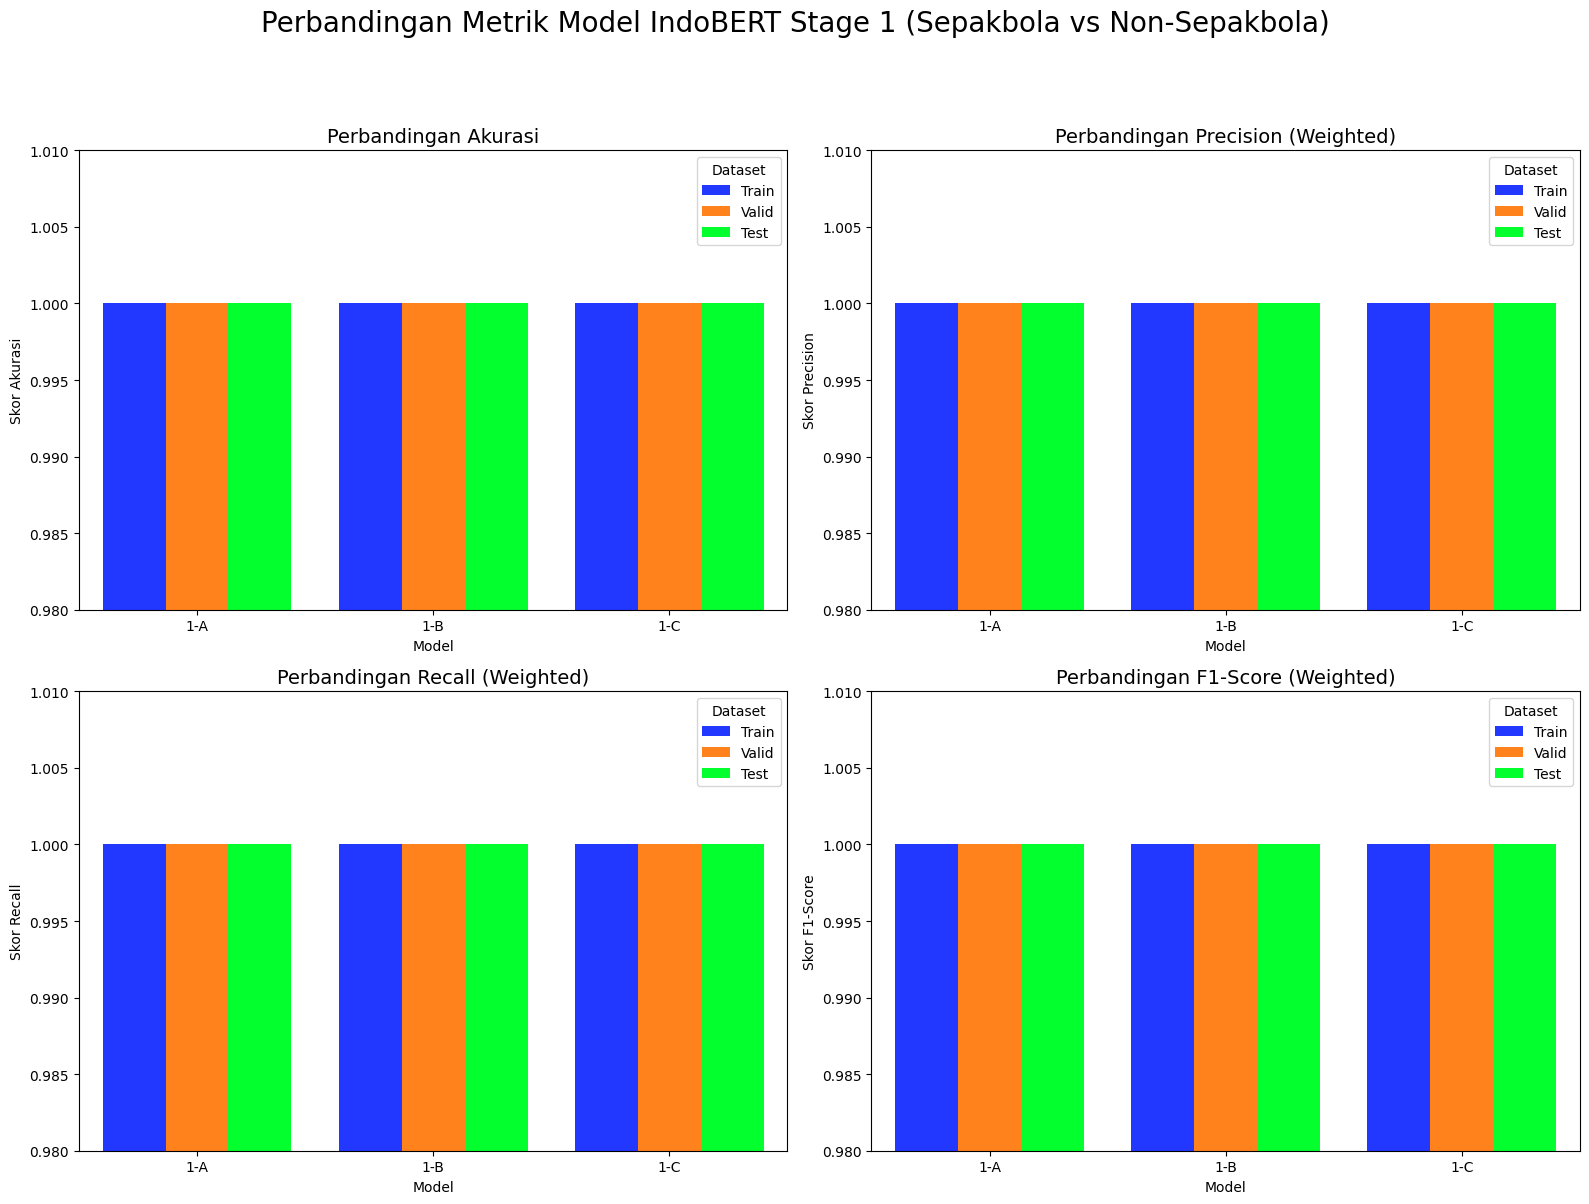

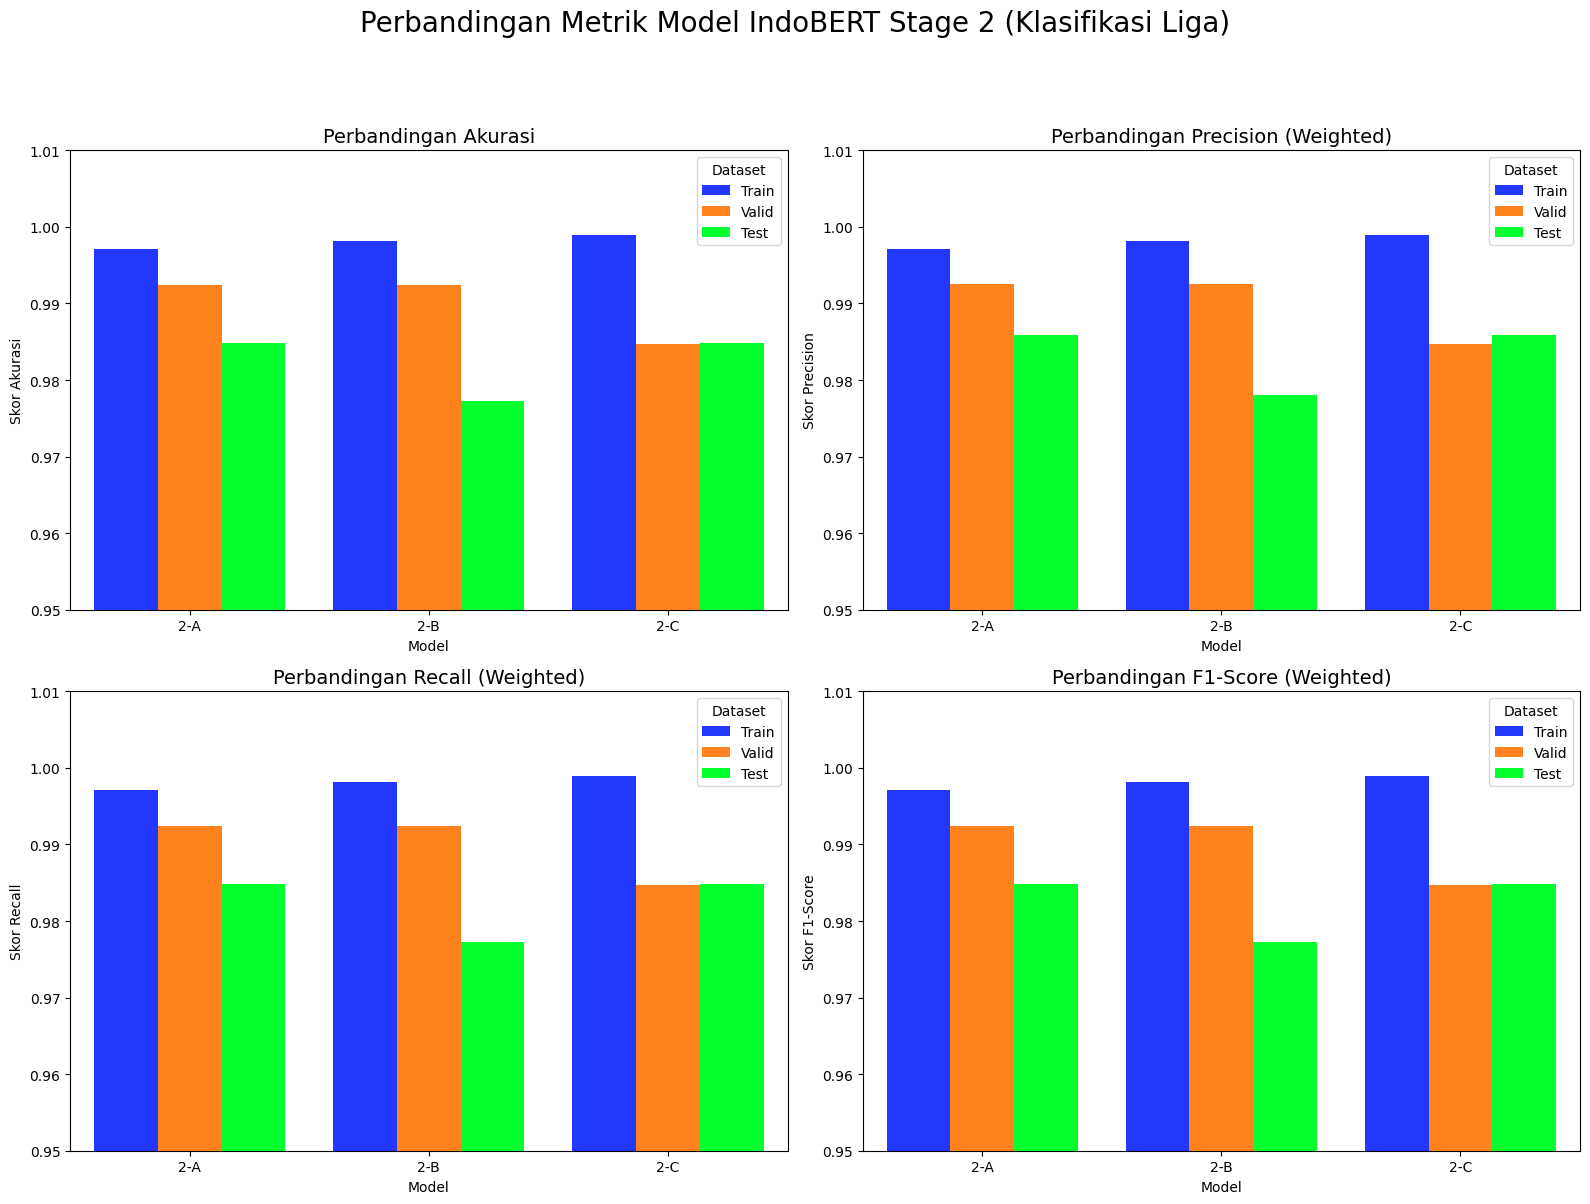

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Menyusun data dari laporan "LLM Indobert 2 Stage" Anda
data = {
    'Model': [
        '1-A', '1-A', '1-A', '1-B', '1-B', '1-B', '1-C', '1-C', '1-C',
        '2-A', '2-A', '2-A', '2-B', '2-B', '2-B', '2-C', '2-C', '2-C'
    ],
    'Dataset': [
        'Train', 'Valid', 'Test', 'Train', 'Valid', 'Test', 'Train', 'Valid', 'Test',
        'Train', 'Valid', 'Test', 'Train', 'Valid', 'Test', 'Train', 'Valid', 'Test'
    ],
    'Stage': [
        1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2
    ],
    'Accuracy': [
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9971, 0.9924, 0.9848, 0.9981, 0.9924, 0.9773, 0.9990, 0.9847, 0.9848
    ],
    'Precision (Weighted)': [
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9971, 0.9926, 0.9859, 0.9981, 0.9926, 0.9780, 0.9990, 0.9847, 0.9859
    ],
    'Recall (Weighted)': [
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9971, 0.9924, 0.9848, 0.9981, 0.9924, 0.9773, 0.9990, 0.9847, 0.9848
    ],
    'F1-Score (Weighted)': [
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9971, 0.9924, 0.9848, 0.9981, 0.9924, 0.9773, 0.9990, 0.9847, 0.9848
    ]
}


df = pd.DataFrame(data)

# Mengubah format data menjadi "long format" agar mudah di-plot dengan seaborn
df_long = df.melt(id_vars=['Model', 'Dataset', 'Stage'], 
                  value_vars=['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
                  var_name='Metric', value_name='Score')

# Memisahkan data untuk Stage 1 dan Stage 2
df_stage1 = df_long[df_long['Stage'] == 1]
df_stage2 = df_long[df_long['Stage'] == 2]

# --- 2. Visualisasi Model IndoBERT Stage 1 (Sepakbola vs Non-Sepakbola) ---

# Mengatur palet warna
palette = {"Train": "#2238ff", "Valid": "#ff821c", "Test": "#04ff2e"}

# Membuat 4 subplot (2 baris, 2 kolom)
fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('Perbandingan Metrik Model IndoBERT Stage 1 (Sepakbola vs Non-Sepakbola)', fontsize=20, y=1.03)

# Plot 1: Accuracy
sns.barplot(ax=axes1[0, 0], data=df_stage1[df_stage1['Metric'] == 'Accuracy'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes1[0, 0].set_title('Perbandingan Akurasi', fontsize=14)
axes1[0, 0].set_ylabel('Skor Akurasi')
axes1[0, 0].set_ylim(0.98, 1.01) # Set limit Y agar performa 100% terlihat jelas
axes1[0, 0].legend(title='Dataset')

# Plot 2: Precision
sns.barplot(ax=axes1[0, 1], data=df_stage1[df_stage1['Metric'] == 'Precision (Weighted)'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes1[0, 1].set_title('Perbandingan Precision (Weighted)', fontsize=14)
axes1[0, 1].set_ylabel('Skor Precision')
axes1[0, 1].set_ylim(0.98, 1.01)
axes1[0, 1].legend(title='Dataset')

# Plot 3: Recall
sns.barplot(ax=axes1[1, 0], data=df_stage1[df_stage1['Metric'] == 'Recall (Weighted)'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes1[1, 0].set_title('Perbandingan Recall (Weighted)', fontsize=14)
axes1[1, 0].set_ylabel('Skor Recall')
axes1[1, 0].set_ylim(0.98, 1.01)
axes1[1, 0].legend(title='Dataset')

# Plot 4: F1-Score
sns.barplot(ax=axes1[1, 1], data=df_stage1[df_stage1['Metric'] == 'F1-Score (Weighted)'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes1[1, 1].set_title('Perbandingan F1-Score (Weighted)', fontsize=14)
axes1[1, 1].set_ylabel('Skor F1-Score')
axes1[1, 1].set_ylim(0.98, 1.01)
axes1[1, 1].legend(title='Dataset')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


# --- 3. Visualisasi Model IndoBERT Stage 2 (Klasifikasi Liga) ---

# Membuat 4 subplot (2 baris, 2 kolom)
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle('Perbandingan Metrik Model IndoBERT Stage 2 (Klasifikasi Liga)', fontsize=20, y=1.03)

# Plot 1: Accuracy
sns.barplot(ax=axes2[0, 0], data=df_stage2[df_stage2['Metric'] == 'Accuracy'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes2[0, 0].set_title('Perbandingan Akurasi', fontsize=14)
axes2[0, 0].set_ylabel('Skor Akurasi')
axes2[0, 0].set_ylim(0.95, 1.01) # Set limit Y dari 0.95 untuk melihat perbedaan kecil
axes2[0, 0].legend(title='Dataset')

# Plot 2: Precision
sns.barplot(ax=axes2[0, 1], data=df_stage2[df_stage2['Metric'] == 'Precision (Weighted)'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes2[0, 1].set_title('Perbandingan Precision (Weighted)', fontsize=14)
axes2[0, 1].set_ylabel('Skor Precision')
axes2[0, 1].set_ylim(0.95, 1.01)
axes2[0, 1].legend(title='Dataset')

# Plot 3: Recall
sns.barplot(ax=axes2[1, 0], data=df_stage2[df_stage2['Metric'] == 'Recall (Weighted)'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes2[1, 0].set_title('Perbandingan Recall (Weighted)', fontsize=14)
axes2[1, 0].set_ylabel('Skor Recall')
axes2[1, 0].set_ylim(0.95, 1.01)
axes2[1, 0].legend(title='Dataset')

# Plot 4: F1-Score
sns.barplot(ax=axes2[1, 1], data=df_stage2[df_stage2['Metric'] == 'F1-Score (Weighted)'],
            x='Model', y='Score', hue='Dataset', palette=palette, saturation=1)
axes2[1, 1].set_title('Perbandingan F1-Score (Weighted)', fontsize=14)
axes2[1, 1].set_ylabel('Skor F1-Score')
axes2[1, 1].set_ylim(0.95, 1.01)
axes2[1, 1].legend(title='Dataset')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()